**DỰ ĐOÁN CHO 7 TUẦN**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
import os
from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, concatenate, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
import time
from datetime import datetime

# **(1) THU THẬP DỮ LIỆU**




Dữ liệu bao gồm 3 loại cổ phiếu của Google, Apple và Netflix trong khoảng 12 năm (từ 11/2010-11/2022). Mỗi cổ phiếu bao gồm 7 cột:

*	Date: chứa thời gian (ngày/tháng/năm) tại thời điểm giao dịch.
*	Open: cho biết giá mà cổ phiếu bắt đầu giao dịch khi thị trường mở cửa vào một ngày cụ thể.
*	High: mức giá cao nhất mà một cổ phiếu được giao dịch trong một khoảng thời gian.
*	Low: cho biết giá thấp nhất trong khoảng thời gian đó.
*	Close: cho biết giá mà cổ phiếu kết thúc giao dịch khi thị trường đóng cửa vào một ngày cụ thể.
*	Adj Close: giá được điều chỉnh lại để xác định giá trị chính xác của cổ phiếu, trong trường hợp công ty có các hoạt động làm thay đổi số lượng cổ phiếu.
*	Volume: tổng khối lượng hoạt động giao dịch trong một khoảng thời gian.


In [ ]:
df_Google = pd.read_csv('/content/drive/Shareddrives/CKI_ML/GOOG.csv')
df_Apple = pd.read_csv('/content/drive/Shareddrives/CKI_ML/AAPL.csv')
df_Netflix = pd.read_csv('/content/drive/Shareddrives/CKI_ML/NFLX.csv')

In [ ]:
df_Google.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-11-01,15.335768,15.458558,15.223190,15.317586,15.317586,123946848
1,2010-11-02,15.408993,15.442119,15.307125,15.332530,15.332530,80203500
2,2010-11-03,15.379853,15.487698,15.280226,15.446602,15.446602,135726838
3,2010-11-04,15.557686,15.689193,15.494423,15.548471,15.548471,143367369
4,2010-11-05,15.521322,15.578857,15.469766,15.568645,15.568645,70892731


Chuyển đổi ngày thành tuần

In [ ]:
# chuyển đổi ngày thành tuần theo rules bên dưới
logic = {'Open'  : 'mean',
         'High'  : 'max',
         'Low'   : 'min',
         'Close' : 'mean',
         'Adj Close' : 'mean',
         'Volume': 'sum'}
df_Google['Date'] = pd.to_datetime(df_Google['Date'])
df_Google = df_Google.set_index('Date')
df_Google = df_Google.sort_index()
df_Google = df_Google.resample('W').apply(logic)
df_Google.index = df_Google.index - pd.tseries.frequencies.to_offset("6D")

df_Apple['Date'] = pd.to_datetime(df_Apple['Date'])
df_Apple = df_Apple.set_index('Date')
df_Apple = df_Apple.sort_index()
df_Apple = df_Apple.resample('W').apply(logic)
df_Apple.index = df_Apple.index - pd.tseries.frequencies.to_offset("6D")

df_Netflix['Date'] = pd.to_datetime(df_Netflix['Date'])
df_Netflix = df_Netflix.set_index('Date')
df_Netflix = df_Netflix.sort_index()
df_Netflix = df_Netflix.resample('W').apply(logic)
df_Netflix.index = df_Netflix.index - pd.tseries.frequencies.to_offset("6D")

In [ ]:
df_Google.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-11-01,15.440724,15.689193,15.223190,15.442767,15.442767,554137286
2010-11-08,15.490886,15.712356,14.974123,15.416963,15.416963,501476639
2010-11-15,14.778805,15.043613,14.479975,14.695567,14.695567,566768455
2010-11-22,14.646663,14.859304,14.401021,14.689939,14.689939,323475940
2010-11-29,14.269514,14.689939,13.781095,14.181793,14.181793,759247218


In [ ]:
df_Apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-11-01,11.100214,11.435000,10.792857,11.155286,9.508964,2369908800
2010-11-08,11.327785,11.475000,10.843929,11.267214,9.604375,2206660400
2010-11-15,10.918214,11.090714,10.634286,10.887786,9.280943,2420040000
2010-11-22,11.097053,11.346429,10.923929,11.177589,9.527978,1563833600
2010-11-29,11.277500,11.392857,11.102500,11.285786,9.620206,2214324000


In [ ]:
df_Netflix.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-11-01,24.499143,24.862858,23.671429,24.181714,24.181714,163346400
2010-11-08,24.459714,25.527143,23.608570,24.702857,24.702857,166178600
2010-11-15,24.038572,24.791430,23.367144,24.050000,24.050000,118524000
2010-11-22,26.662858,27.497143,25.857143,27.025000,27.025000,169008000
2010-11-29,28.250571,29.891430,26.371429,28.109429,28.109429,330197700


In [ ]:
columns_Google = list(df_Google.columns)
columns_Apple = list(df_Google.columns)
columns_Netflix = list(df_Google.columns)
print(columns_Google)
print(columns_Apple)
print(columns_Netflix)

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


In [ ]:
df_Google.info()
df_Apple.info()
df_Netflix.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 627 entries, 2010-11-01 to 2022-10-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       627 non-null    float64
 1   High       627 non-null    float64
 2   Low        627 non-null    float64
 3   Close      627 non-null    float64
 4   Adj Close  627 non-null    float64
 5   Volume     627 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 34.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 627 entries, 2010-11-01 to 2022-10-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       627 non-null    float64
 1   High       627 non-null    float64
 2   Low        627 non-null    float64
 3   Close      627 non-null    float64
 4   Adj Close  627 non-null    float64
 5   Volume     627 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 34.3 KB
<class 'pand

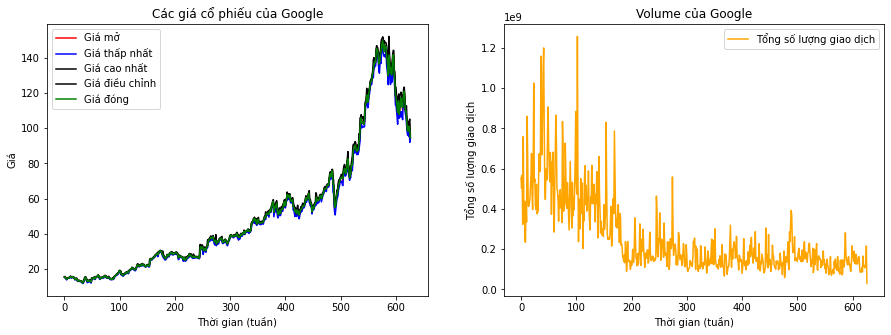

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(df_Google.Open.values, color='red', label='Giá mở')
plt.plot(df_Google.Low.values, color='blue', label='Giá thấp nhất')
plt.plot(df_Google.High.values, color='black', label='Giá cao nhất')
plt.plot(df_Google['Adj Close'].values, color='black', label='Giá điều chỉnh')
plt.plot(df_Google.Close.values, color='green', label='Giá đóng')
plt.title('Các giá cổ phiếu của Google')
plt.xlabel('Thời gian (tuần)')
plt.ylabel('Giá')
plt.legend(loc='best')

plt.subplot(1,2,2);
plt.plot(df_Google.Volume.values, color='orange', label='Tổng số lượng giao dịch')
plt.title('Volume của Google')
plt.xlabel('Thời gian (tuần)')
plt.ylabel('Tổng số lượng giao dịch')
plt.legend(loc='best');

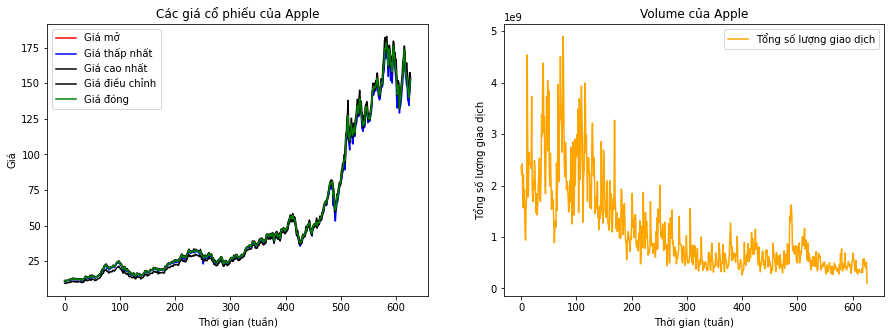

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(df_Apple.Open.values, color='red', label='Giá mở')
plt.plot(df_Apple.Low.values, color='blue', label='Giá thấp nhất')
plt.plot(df_Apple.High.values, color='black', label='Giá cao nhất')
plt.plot(df_Apple['Adj Close'].values, color='black', label='Giá điều chỉnh')
plt.plot(df_Apple.Close.values, color='green', label='Giá đóng')
plt.title('Các giá cổ phiếu của Apple')
plt.xlabel('Thời gian (tuần)')
plt.ylabel('Giá')
plt.legend(loc='best')

plt.subplot(1,2,2);
plt.plot(df_Apple.Volume.values, color='orange', label='Tổng số lượng giao dịch')
plt.title('Volume của Apple')
plt.xlabel('Thời gian (tuần)')
plt.ylabel('Tổng số lượng giao dịch')
plt.legend(loc='best');

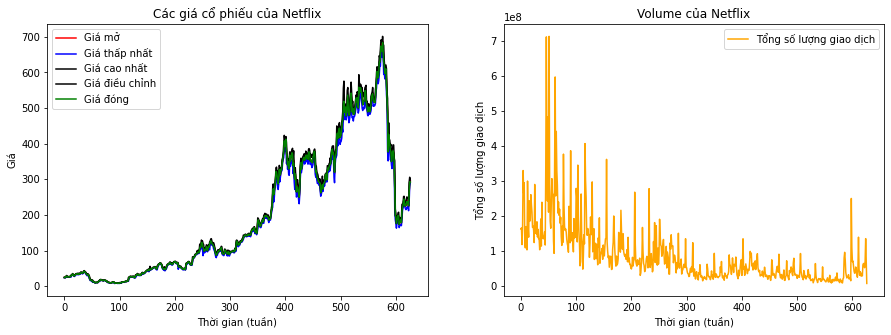

In [ ]:
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(df_Netflix.Open.values, color='red', label='Giá mở')
plt.plot(df_Netflix.Low.values, color='blue', label='Giá thấp nhất')
plt.plot(df_Netflix.High.values, color='black', label='Giá cao nhất')
plt.plot(df_Netflix['Adj Close'].values, color='black', label='Giá điều chỉnh')
plt.plot(df_Netflix.Close.values, color='green', label='Giá đóng')
plt.title('Các giá cổ phiếu của Netflix')
plt.xlabel('Thời gian (tuần)')
plt.ylabel('Giá')
plt.legend(loc='best')

plt.subplot(1,2,2);
plt.plot(df_Netflix.Volume.values, color='orange', label='Tổng số lượng giao dịch')
plt.title('Volume của Netflix')
plt.xlabel('Thời gian (tuần)')
plt.ylabel('Tổng số lượng giao dịch')
plt.legend(loc='best');

Xử lý dữ liệu

In [ ]:
# kiểm tra dữ liệu của các cột của từng mã có tuần nào null hay không
print(df_Google.isnull().sum())
print(df_Apple.isnull().sum())
print(df_Netflix.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


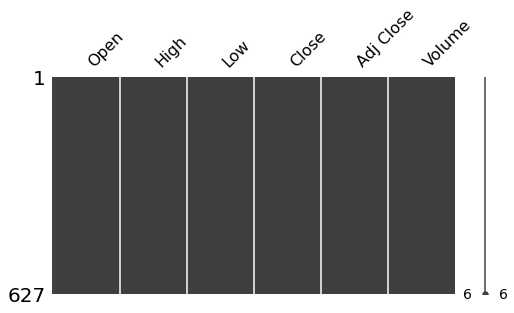

In [ ]:
import missingno as msno
msno.matrix(df_Google, figsize=(8, 4))
# df_Google
# df_Apple
# df_Netflix

# **CỔ PHIẾU NETFLIX**

## Với bộ dữ liệu đã chuyển đổi thành tuần

### **(2) PHÂN TÍCH BÀI TOÁN**

Với giá của phiếu chúng ta sẽ chọn giá điều chỉnh, giá đóng, giá mở,... để dự đoán cho tương lai

In [ ]:
data_netflix = df_Netflix

In [ ]:
data_netflix.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-11-01,24.499143,24.862858,23.671429,24.181714,24.181714,163346400
2010-11-08,24.459714,25.527143,23.608570,24.702857,24.702857,166178600
2010-11-15,24.038572,24.791430,23.367144,24.050000,24.050000,118524000
2010-11-22,26.662858,27.497143,25.857143,27.025000,27.025000,169008000
2010-11-29,28.250571,29.891430,26.371429,28.109429,28.109429,330197700


In [ ]:
def split_sequences(data_stock, training_set_scaled, time_step, split_percent):
  split = int(split_percent*len(training_set_scaled)) #split percent multiplying by data rows

  X = []
  y = []
  for i in range(time_step + 1, len(training_set_scaled)):
    X.append(training_set_scaled[i-time_step-1:i-1, 0:len(data_stock.columns)]) #dung 60 tuần de du doan tuần thứ 61
    y.append(training_set_scaled[i,0:len(data_stock.columns)]) #lấy tất cả các cột vào set và trừ đi 2 cột

  X_arr, y_arr = np.array(X), np.array(y)

  #Split data
  X_train = X_arr[:split] #(80%) model train input data
  y_train = y_arr[:split] #80%) model train target data
  X_test = X_arr[split:] #(20%) test prediction input data
  y_test = y_arr[split:] #(20%) test prediction compare data

  #Reshaping lại rows/time_step/columns
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2])) #(samples, time-steps, features)
  y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1])) #(samples, time-steps, features)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) #(samples, time-steps, features)
  y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1])) #(samples, time-steps, features)

  return X_train, y_train, X_test, y_test

In [ ]:
future_prediction = 7 # 7 tuần
time_step = 60 #learning step: để giảm lỗi số của kết quả tính toán, giúp chia tập X,y
split_percent = 0.80 #train/test data split (80%)

In [ ]:
training_set = data_netflix.values 

# Normalize dữ liệu
sc = MinMaxScaler(feature_range = [0,1])
training_set_scaled = sc.fit_transform(training_set)

### **(3) XÂY DỰNG CÁC MÔ HÌNH**

In [ ]:
# Hàm tính thời gian train và test
def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        return str(thour) + " giờ : "+ str(tmin) +' phút : ' + str(round(tsec,2)) + ' giây' #hour:min:sec

#### 3.1 Mô hình RNN

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_netflix,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# RNN
def rnn():
  regressor_rnn = Sequential()
  regressor_rnn.add(SimpleRNN(units=100, activation='relu',
                        input_shape = (X_train.shape[1], X_train.shape[2])))
  regressor_rnn.add(RepeatVector(6))
  regressor_rnn.add(SimpleRNN(units=100, activation='relu', return_sequences = True))
  regressor_rnn.add(TimeDistributed(Dense(1))) # `TimeDistributed` Layer phải được chuyển qua `input_shape ` với ít nhât 3 dimen

  # Bien dich RNN
  regressor_rnn.compile(optimizer='adam', loss = 'mse', metrics=['mae'])#mean_squared_error
  regressor_rnn.summary()
  return regressor_rnn

In [ ]:
# huấn luyện mô hình
regressor_rnn = rnn()
start_time=timer(None)
history = regressor_rnn.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split=0.2, verbose=1)
mae = history.history['mae']
rnn_mae = round(float(mae[-1]), 5)
time_train_rnn = timer(start_time)
print('Training time -', timer(start_time))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10700     
                                                                 
 repeat_vector (RepeatVector  (None, 6, 100)           0         
 )                                                               
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 6, 100)            20100     
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             101       
 ibuted)                                                         
                                                                 
Total params: 30,901
Trainable params: 30,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
13/13 [==============================] - 4

3/3 [==============================] - 0s 9ms/step
Testing time - 0.0 giờ : 0.0 phút : 0.56 giây
(65, 6, 1)


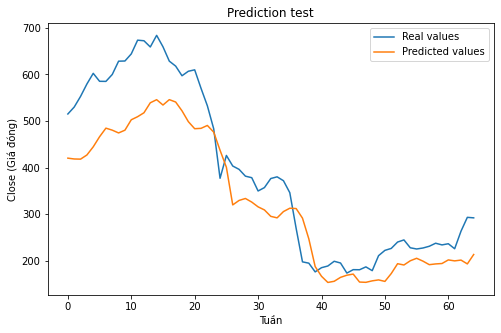

In [ ]:
start_time=timer(None)
#Test result
y_pred = regressor_rnn.predict(X_test)#verbose=1
print('Testing time -', timer(start_time))
time_test_rnn = timer(start_time)
print(y_pred.shape) #cần reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_rnn = sc.inverse_transform(y_test_inv)
y_pred_rnn = sc.inverse_transform(y_pred)


plt.figure(figsize=(8,5))
plt.plot(y_test_rnn[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo bằng RNN và Vẽ đồ thị

In [ ]:
df_netflix_real_pred = data_netflix # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_netflix = df_netflix_real_pred.iloc[-time_step:]
  X_input = df_netflix.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1])) # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array

  simple_RNN_prediction = regressor_rnn.predict(X_input) # dự đoán cho tuần thứ 61
  simple_RNN_prediction.shape
  simple_RNN_prediction = np.reshape(simple_RNN_prediction, (simple_RNN_prediction.shape[0], 6)) #reshapethành (1, 1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  simple_RNN_prediction = sc.inverse_transform(simple_RNN_prediction)
  print("Simple RNN, Giá đóng cửa cho tuần " + str(week) +":", simple_RNN_prediction[0,1])
  a= simple_RNN_prediction[0,1]
  # Đưa dữ liệu vào bộ train
  df_netflix_predicted = pd.DataFrame(simple_RNN_prediction, columns=df_netflix.columns)
  data = [df_netflix_real_pred, df_netflix_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_netflix_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_netflix_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_netflix_real_pred,training_set_scaled,
                                                  time_step, split_percent)
  # huấn luyện lại mô hình
  regressor_rnn.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split=0.2, verbose=1)


1/1 [==============================] - 0s 35ms/step
Simple RNN, Giá đóng cửa cho tuần 1: 300.9941
Epoch 1/5
13/13 [==============================] - 0s 38ms/step - loss: 0.0091 - mae: 0.0545 - val_loss: 0.0558 - val_mae: 0.1627
Epoch 2/5
13/13 [==============================] - 0s 38ms/step - loss: 0.0091 - mae: 0.0534 - val_loss: 0.0556 - val_mae: 0.1724
Epoch 3/5
13/13 [==============================] - 0s 36ms/step - loss: 0.0090 - mae: 0.0538 - val_loss: 0.0557 - val_mae: 0.1754
Epoch 4/5
13/13 [==============================] - 0s 35ms/step - loss: 0.0091 - mae: 0.0540 - val_loss: 0.0556 - val_mae: 0.1728
Epoch 5/5
1/1 [==============================] - 0s 29ms/step
Simple RNN, Giá đóng cửa cho tuần 2: 283.33456
Epoch 1/5
13/13 [==============================] - 0s 38ms/step - loss: 0.0090 - mae: 0.0537 - val_loss: 0.0558 - val_mae: 0.1786
Epoch 2/5
13/13 [==============================] - 1s 40ms/step - loss: 0.0090 - mae: 0.0543 - val_loss: 0.0557 - val_mae: 0.1670
Epoch 3/5
13/

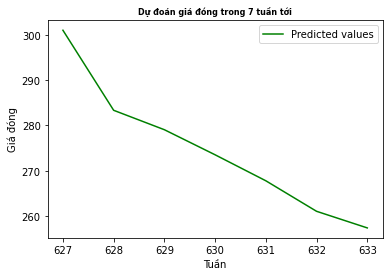

In [ ]:
plt.plot(df_netflix_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột Close price
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

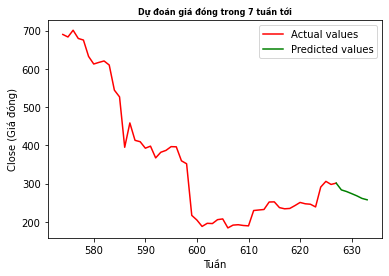

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_netflix_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_netflix_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột Close price
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

#### 3.2 Mô hình MLP

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_netflix,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train2 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train2 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
def mlp():
  regressor_mlp = Sequential()
  regressor_mlp.add(Dense(units=100, activation = "relu", input_dim=n_input))
  regressor_mlp.add(Dense(units=100, activation = "relu"))
  regressor_mlp.add(Dense(n_output))
  # Bien dich MLP
  regressor_mlp.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
  regressor_mlp.summary()
  return regressor_mlp

In [ ]:
# huấn luyện mô hình
regressor_mlp = mlp()
start_time=timer(None)
history = regressor_mlp.fit(X_train2, y_train2, epochs = 5, batch_size = 32, validation_split=0.2, verbose = 1)
mae = history.history['mae']
mlp_mae = round(float(mae[-1]), 5)
print('Training time -', timer(start_time))
time_train_mlp = timer(start_time)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 100)               36100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 46,806
Trainable params: 46,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
13/13 [==============================] - 2s 43ms/step - loss: 0.0172 - mae: 0.0865 - val_loss: 0.0130 - val_mae: 0.0922
Epoch 2/5
13/13 [==============================] - 0s 10ms/step - loss: 0.0046 - mae: 0.0474 - val_loss: 0.0131 - val_mae: 0.0965
Epoch 3/5
13/13 [==============================] - 0s 

3/3 [==============================] - 0s 6ms/step
Testing time - 0.0 giờ : 0.0 phút : 0.2 giây
(65, 6)


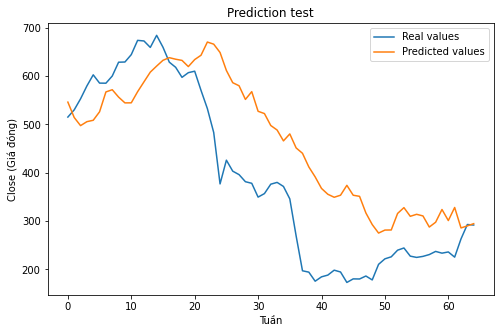

In [ ]:
X_test2 = X_test.reshape((X_test.shape[0], n_input))
start_time=timer(None)
#Test results
y_pred = regressor_mlp.predict(X_test2)
time_test_mlp = timer(start_time)
print('Testing time -', timer(start_time))
print(y_pred.shape) #(65, 6)

#Reshape dữ liệu cho inverse transforming
y_test2 = y_test.reshape((y_test.shape[0], n_output)) #reshape(65, 6)
# y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_mlp = sc.inverse_transform(y_test2)
y_pred_mlp = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_mlp[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo bằng MLP và Vẽ đồ thị

In [ ]:
df_netflix_real_pred = data_netflix # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán
week = 0
for i in range(future_prediction):
  week += 1
  df_netflix = df_netflix_real_pred.iloc[-time_step:]
  X_input = df_netflix.values
  X_input = sc.fit_transform(X_input) # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = X_input.reshape(1, n_input) # 1 phần tử chứa 540 

  mlp_prediction = regressor_mlp.predict(X_input)
  mlp_prediction = np.reshape(mlp_prediction, (mlp_prediction.shape[0], 6)) #reshape (1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  mlp_prediction = sc.inverse_transform(mlp_prediction)
  print("MLP, Giá đóng cửa cho tuần " + str(week) +":", mlp_prediction[0,1])
  
  # Đưa dữ liệu vào bộ train
  df_netflix_predicted = pd.DataFrame(mlp_prediction, columns=df_netflix.columns)
  data = [df_netflix_real_pred, df_netflix_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_netflix_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_netflix_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_netflix_real_pred,training_set_scaled,
                                                  time_step, split_percent)

  # flatten input
  n_input = X_train.shape[1] * X_train.shape[2]
  X_train2 = X_train.reshape((X_train.shape[0], n_input))
  n_output = y_train.shape[2]
  y_train2 = y_train.reshape((y_train.shape[0], n_output))

  # huấn luyện lại mô hình
  regressor_mlp.fit(X_train2, y_train2, epochs = 5, batch_size = 32, validation_split=0.2, verbose= 1)


1/1 [==============================] - 0s 33ms/step
MLP, Giá đóng cửa cho tuần 1: 368.07584
Epoch 1/5
13/13 [==============================] - 0s 13ms/step - loss: 0.0020 - mae: 0.0300 - val_loss: 0.0049 - val_mae: 0.0565
Epoch 2/5
13/13 [==============================] - 0s 10ms/step - loss: 0.0018 - mae: 0.0291 - val_loss: 0.0046 - val_mae: 0.0526
Epoch 3/5
13/13 [==============================] - 0s 10ms/step - loss: 0.0020 - mae: 0.0299 - val_loss: 0.0129 - val_mae: 0.0916
Epoch 4/5
13/13 [==============================] - 0s 10ms/step - loss: 0.0020 - mae: 0.0297 - val_loss: 0.0046 - val_mae: 0.0547
Epoch 5/5
1/1 [==============================] - 0s 106ms/step
MLP, Giá đóng cửa cho tuần 2: 361.40454
Epoch 1/5
13/13 [==============================] - 0s 15ms/step - loss: 0.0013 - mae: 0.0252 - val_loss: 0.0064 - val_mae: 0.0664
Epoch 2/5
13/13 [==============================] - 0s 11ms/step - loss: 0.0013 - mae: 0.0243 - val_loss: 0.0024 - val_mae: 0.0388
Epoch 3/5
13/13 [========

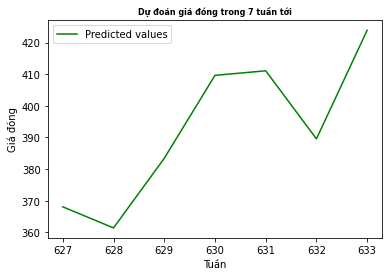

In [ ]:
plt.plot(df_netflix_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

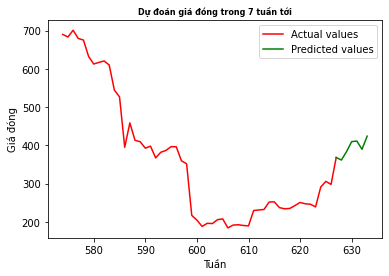

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_netflix_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_netflix_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

#### 3.3 Mô hình Random Forest

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_netflix,training_set_scaled,
                                                  time_step, split_percent)
# (2416, 60, 6), (2416, 1, 6), (65, 60, 6), (65, 1, 6)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2] 
X_train3 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train3 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor() # không parameter để test overfitting
start_time=timer(None)
regressor_rf.fit(X_train3, y_train3)
time_train_rf = timer(start_time)
print('Training time -', timer(start_time))

Training time - 0.0 giờ : 0.0 phút : 7.61 giây


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
X_test3 = X_test.reshape((X_test.shape[0], n_input))
y_test3 = y_test.reshape((y_test.shape[0], n_output))
#Test results
start_time=timer(None)
y_pred = regressor_rf.predict(X_test3)
time_test_rf = timer(start_time)
rf_mae = mean_absolute_error(y_test3, y_pred)
print('Testing time -', timer(start_time))
print('Mean Absolute Error:', rf_mae)
print('Mean Squared Error:', mean_squared_error(y_test3, y_pred))

Testing time - 0.0 giờ : 0.0 phút : 0.01 giây
Mean Absolute Error: 0.09842049184944873
Mean Squared Error: 0.014344292688787473


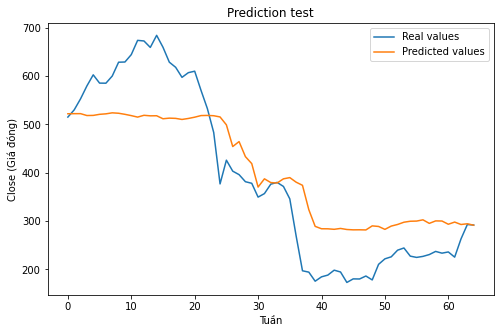

In [ ]:
#Reversing transform để có được giá trị dữ liệu thích hợp
y_test_rf = sc.inverse_transform(y_test3)
y_pred_rf = sc.inverse_transform(y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_test_rf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo bằng Random Forest và Vẽ đồ thị

In [ ]:
df_netflix_real_pred = data_netflix  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
df_netflix_real_pred.shape

(627, 6)

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_netflix_pred = df_netflix_real_pred.iloc[-time_step:]
  X_input = df_netflix_pred.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = X_input.reshape(1, n_input) # 1 phần tử chứa 540 # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array
  print(X_input.shape)
  rf_prediction = regressor_rf.predict(X_input)
  # y_pred = regressor_rf.predict(X_test3)
  rf_prediction = np.reshape(rf_prediction, (rf_prediction.shape[0], 6)) #reshaping for (1, 6)
   #inverse transform để có được giá trị dữ liệu phù hợp
  rf_prediction = sc.inverse_transform(rf_prediction)
  print("Random Forest, Giá đóng cửa cho tuần " + str(week) +":", rf_prediction[0,1])
  
  # Đưa dữ liệu vào bộ train
  df_netflix_predicted = pd.DataFrame(rf_prediction, columns=df_netflix.columns)
  data = [df_netflix_real_pred, df_netflix_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_netflix_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_netflix_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_netflix_real_pred,training_set_scaled,
                                                  time_step, split_percent)

  # flatten input
  n_input = X_train.shape[1] * X_train.shape[2]
  X_train3 = X_train.reshape((X_train.shape[0], n_input))
  n_output = y_train.shape[2]
  y_train3 = y_train.reshape((y_train.shape[0], n_output))

  # huấn luyện lại mô hình
  regressor_rf.fit(X_train3, y_train3)


(1, 360)
Random Forest, Giá đóng cửa cho tuần 1: 365.3014428957441
(1, 360)
Random Forest, Giá đóng cửa cho tuần 2: 379.3940086379338
(1, 360)
Random Forest, Giá đóng cửa cho tuần 3: 382.7929483362305
(1, 360)
Random Forest, Giá đóng cửa cho tuần 4: 382.76301297166015
(1, 360)
Random Forest, Giá đóng cửa cho tuần 5: 386.7959787685079
(1, 360)
Random Forest, Giá đóng cửa cho tuần 6: 382.23260499811846
(1, 360)
Random Forest, Giá đóng cửa cho tuần 7: 388.83661225191406


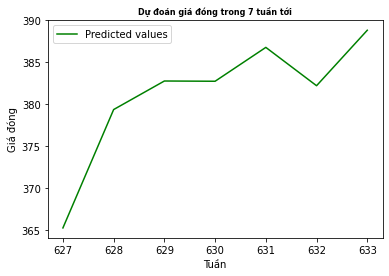

In [ ]:
plt.plot(df_netflix_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

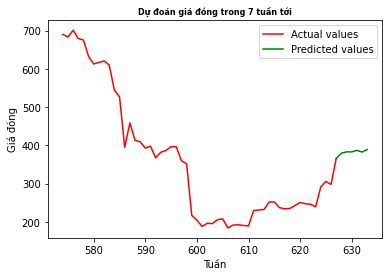

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_netflix_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_netflix_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

#### 3.4 Đánh giá độ đo MAE và so sánh

In [ ]:
compare = pd.DataFrame({'Model': ['RNN', 'MLP', 'Random Forest'], 
                        'Mean Absolute Error': [rnn_mae, mlp_mae,  rf_mae]})
compare.sort_values(by='Mean Absolute Error', ascending=True)

,Model,Mean Absolute Error
1,MLP,0.03206
0,RNN,0.05348
2,Random Forest,0.09842


#### 3.5 Thời gian Training và Testing

In [ ]:
compare = pd.DataFrame({'Model': ['RNN', 'MLP', 'Random Forest'], 
                        'Training time': [time_train_rnn, time_train_mlp,  time_train_rf]})
compare.sort_values(by='Training time', ascending=True)

,Model,Training time
1,MLP,0.0 giờ : 0.0 phút : 2.26 giây
0,RNN,0.0 giờ : 0.0 phút : 6.08 giây
2,Random Forest,0.0 giờ : 0.0 phút : 7.61 giây


In [ ]:
compare = pd.DataFrame({'Model': ['RNN', 'MLP', 'Random Forest'], 
                        'Testing time': [time_test_rnn, time_test_mlp,  time_test_rf]})
compare.sort_values(by='Testing time', ascending=True)

,Model,Testing time
2,Random Forest,0.0 giờ : 0.0 phút : 0.01 giây
1,MLP,0.0 giờ : 0.0 phút : 0.2 giây
0,RNN,0.0 giờ : 0.0 phút : 0.57 giây


###(4) XỬ LÝ OVERFITTING VÀ SO SÁNH

In [ ]:
early_stopping = EarlyStopping(patience=2, min_delta=0.0001, monitor="val_loss", verbose=1)

#### 4.1 Mô hình RNN

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_netflix,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
regressor_rnn = Sequential()
regressor_rnn.add(SimpleRNN(units=100, activation='relu',
                        input_shape = (X_train.shape[1], X_train.shape[2])))
regressor_rnn.add(Dropout(0.2))
regressor_rnn.add(RepeatVector(6))
regressor_rnn.add(SimpleRNN(units=100, activation='relu', return_sequences = True))
regressor_rnn.add(Dropout(0.2))
regressor_rnn.add(TimeDistributed(Dense(1))) # `TimeDistributed` Layer phải được chuyển qua `input_shape ` với ít nhât 3 dimen

# Bien dich RNN
regressor_rnn.compile(optimizer='adam', loss = 'mse', metrics=['mae'])#mean_squared_error
regressor_rnn.summary()

# huấn luyện mô hình RNN đã dropout với early stopping
regressor_rnn.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split=0.2, callbacks=[early_stopping],verbose=1)
# callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]) validation_split=0.2 verbose=1

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               10700     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 6, 100)           0         
 or)                                                             
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 6, 100)            20100     
                                                                 
 dropout_1 (Dropout)         (None, 6, 100)            0         
                                                                 
 time_distributed_1 (TimeDis  (None, 6, 1)             101       
 tributed)                                            

3/3 [==============================] - 0s 6ms/step
(65, 6, 1)


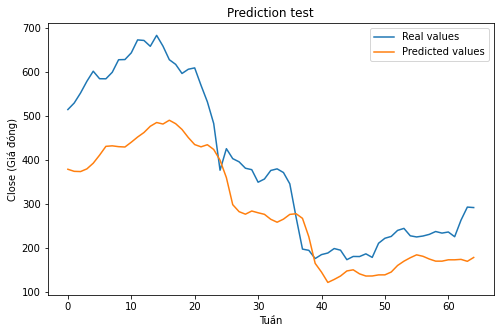

In [ ]:
#Test results
y_pred = regressor_rnn.predict(X_test)#verbose=1
print(y_pred.shape) #cần reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_rnn_ovf = sc.inverse_transform(y_test_inv)
y_pred_rnn_ovf = sc.inverse_transform(y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_test_rnn_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

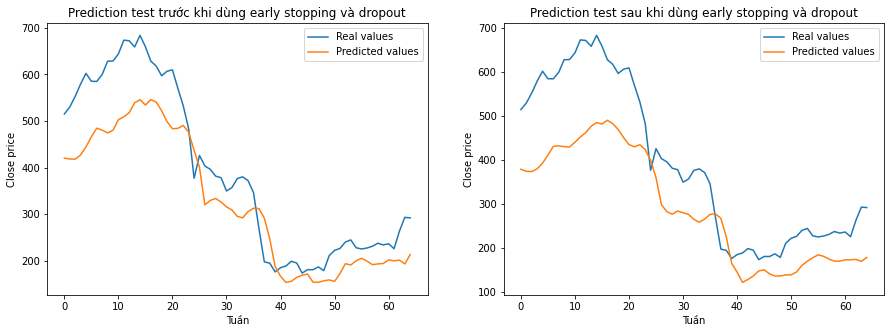

In [ ]:
# so sánh trước và sau khi xử lý overfiting
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(y_test_rnn[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test trước khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close price')
#plt.ylim([15, 28])
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(y_test_rnn_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test sau khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close price')
#plt.ylim([15, 28])
plt.legend()

#### 4.2 Mô hình MLP

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_netflix,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train2 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train2 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
regressor_mlp = Sequential()
regressor_mlp.add(Dense(units=100, activation = "relu", input_dim=n_input))
regressor_mlp.add(Dropout(0.2))
regressor_mlp.add(Dense(units=100, activation = "relu"))
regressor_mlp.add(Dropout(0.2))
regressor_mlp.add(Dense(n_output))
# Bien dich MLP
regressor_mlp.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
regressor_mlp.summary()
# huấn luyện mô hình
regressor_mlp.fit(X_train2, y_train2, epochs = 5, batch_size = 32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               36100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 6)                 606       
                                                                 
Total params: 46,806
Trainable params: 46,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
13/13 [==============================] -

3/3 [==============================] - 0s 4ms/step
(65, 6)


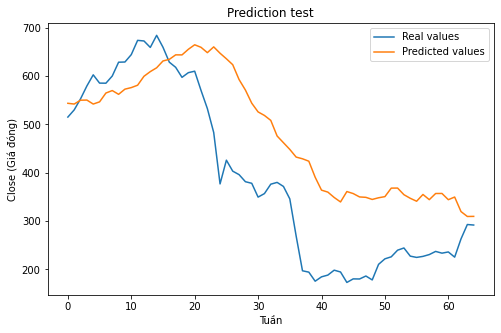

In [ ]:
# regressor.fit(X_train2, y_train, epochs = 5, batch_size = 32)
X_test2 = X_test.reshape((X_test.shape[0], n_input))

#Test results
y_pred = regressor_mlp.predict(X_test2)
print(y_pred.shape) #(65, 6)

#Reshape dữ liệu cho inverse transforming
y_test2 = y_test.reshape((y_test.shape[0], n_output)) #reshape (65, 6)
# y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_mlp_ovf = sc.inverse_transform(y_test2)
y_pred_mlp_ovf = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_mlp_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

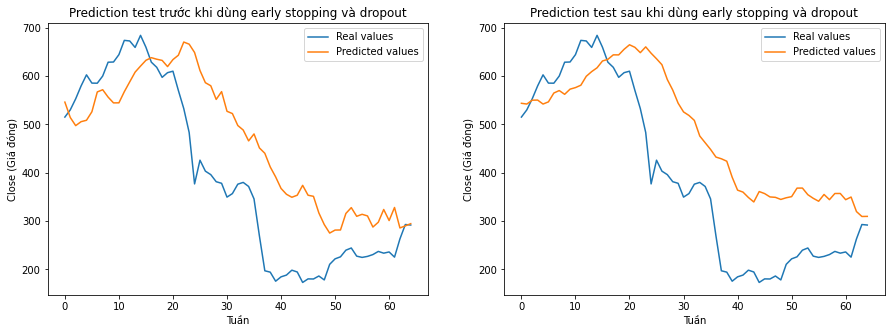

In [ ]:
# so sánh trước và sau khi xử lý overfiting
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(y_test_mlp[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test trước khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(y_test_mlp_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test sau khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

#### 4.3 Mô hình Random forest

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_netflix,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train3 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train3 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
# Tìm tham số tốt nhất để xử lý overfitting
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 5 , stop = 15, num = 10)] # returns 10 numbers 

max_features = ['auto', 'log2']

max_depth = [int(x) for x in np.linspace(5, 10, num = 2)] 

max_depth.append(None)

bootstrap = [True, False]

r_grid = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'bootstrap': bootstrap}
          
rfr = RandomForestRegressor(random_state = 1)

rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=r_grid, n_iter = 20, 
                                scoring='neg_mean_absolute_error', cv = 3, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)

rfr_random.fit(X_train3, y_train3)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, None],
                                        'max_features': ['auto', 'log2'],
                                        'n_estimators': [5, 6, 7, 8, 9, 10, 11,
                                                         12, 13, 15]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print(rfr_random.best_params_)

{'n_estimators': 7, 'max_features': 'auto', 'max_depth': 5, 'bootstrap': False}


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# có thể sử dụng nhiều tham số để loại bỏ phần thừa một cách dễ dàng
regressor_rf = RandomForestRegressor(n_estimators= 7, max_features= 'auto', 
                                     max_depth= 5, bootstrap= False) 
regressor_rf.fit(X_train3, y_train3)

RandomForestRegressor(bootstrap=False, max_depth=5, n_estimators=7)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
X_test3 = X_test.reshape((X_test.shape[0], n_input))
y_test3 = y_test.reshape((y_test.shape[0], n_output)) # (65, 1, 6) -> (65, 6)
#Test results
y_pred = regressor_rf.predict(X_test3)
print('Mean Absolute Error:', mean_absolute_error(y_test3, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test3, y_pred))

Mean Absolute Error: 0.08058261088924332
Mean Squared Error: 0.011867170111263705


In [ ]:
y_test.shape

(65, 1, 6)

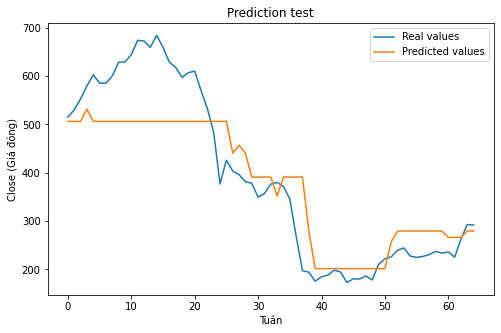

In [ ]:
#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_rf_ovf = sc.inverse_transform(y_test3)
y_pred_rf_ovf = sc.inverse_transform(y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_test_rf_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

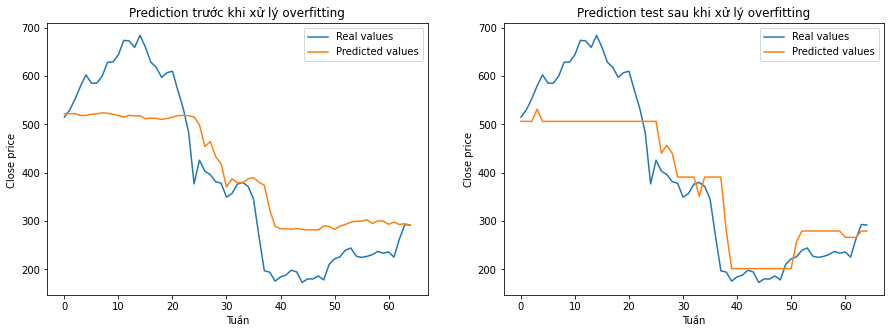

In [ ]:
# so sánh trước và sau khi xử lý overfiting
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(y_test_rf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction trước khi xử lý overfitting')
plt.xlabel('Tuần')
plt.ylabel('Close price ')
#plt.ylim([15, 28])
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(y_test_rf_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test sau khi xử lý overfitting')
plt.xlabel('Tuần')
plt.ylabel('Close price')
#plt.ylim([15, 28])
plt.legend()

###(5) TÌM ĐẶC TRƯNG QUAN TRỌNG NHẤT

In [ ]:
# Feature selection bằng ExtraTreesRegressor(dựa trên mô hình)
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc

In [ ]:
df_netflix = df_netflix
X = df_netflix.drop(['Close'], axis=1)
y = df_netflix['Close']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [ ]:
reg= ExtraTreesRegressor()
reg.fit(X_train,y_train)

ExtraTreesRegressor()

In [ ]:
reg.feature_importances_

array([0.20518176, 0.31972415, 0.20968926, 0.25927571, 0.00612912])

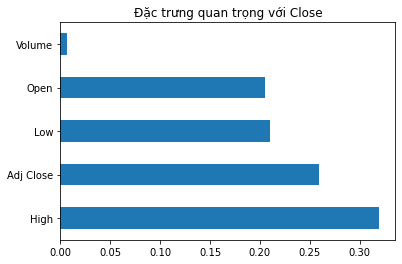

In [ ]:
feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh', title='Đặc trưng quan trọng với Close')
plt.show()

In [ ]:
feat_importances

Open         0.205182
High         0.319724
Low          0.209689
Adj Close    0.259276
Volume       0.006129
dtype: float64

In [ ]:
feat_importances[feat_importances == max(feat_importances)].index

Index(['High'], dtype='object')

### (6) MÔ HÌNH DEEP LEARNING

#### 6.1 Mô hình LSTM

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_netflix,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# LSTM
def lstm():
  regressor_lstm = Sequential()
  regressor_lstm.add(LSTM(units=100,input_shape = (X_train.shape[1], X_train.shape[2])))
  regressor_lstm.add(Dropout(0.2))
  regressor_lstm.add(RepeatVector(6))
  regressor_lstm.add(LSTM(units=100, return_sequences = True))
  regressor_lstm.add(Dropout(0.2))
  regressor_lstm.add(TimeDistributed(Dense(1))) # `TimeDistributed` Layer phải được chuyển qua `input_shape ` với ít nhât 3 dimen

  # Bien dich LSTM
  regressor_lstm.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
  regressor_lstm.summary()
  return regressor_lstm

In [ ]:
# huấn luyện mô hình
regressor_lstm = lstm()
regressor_lstm.fit(X_train, y_train, epochs = 5, batch_size = 32,  shuffle = False)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42800     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 6, 100)           0         
 or)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 6, 100)            80400     
                                                                 
 dropout_5 (Dropout)         (None, 6, 100)            0         
                                                                 
 time_distributed_2 (TimeDis  (None, 6, 1)             101       
 tributed)                                            

3/3 [==============================] - 1s 12ms/step
(65, 6, 1)


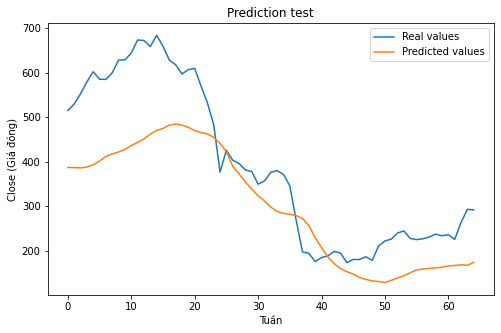

In [ ]:
#Test results
y_pred = regressor_lstm.predict(X_test)
print(y_pred.shape) #(65, 6, 1)  reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_inv = sc.inverse_transform(y_test_inv)
y_pred_lstm = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_inv[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_lstm[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán "
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo và Vẽ đồ thị

In [ ]:
df_netflix_real_pred = data_netflix # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_netflix = df_netflix_real_pred.iloc[-time_step:]
  X_input = df_netflix.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1])) # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array

  LSTM_prediction = regressor_lstm.predict(X_input) # dự đoán cho tuần thứ 61
  LSTM_prediction.shape
  LSTM_prediction = np.reshape(LSTM_prediction, (LSTM_prediction.shape[0], 6)) #reshaping for (1, 1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  LSTM_prediction = sc.inverse_transform(LSTM_prediction)
  print("LSTM, Giá đóng cửa cho tuần " + str(week) +":", LSTM_prediction[0,1])

  # Đưa dữ liệu vào bộ train
  df_netflix_predicted = pd.DataFrame(LSTM_prediction, columns=df_netflix.columns)
  data = [df_netflix_real_pred, df_netflix_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_netflix_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_netflix_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_netflix_real_pred,training_set_scaled,
                                                  time_step, split_percent)
  # huấn luyện lại mô hình
  regressor_lstm.fit(X_train, y_train, epochs = 5, batch_size = 32)


1/1 [==============================] - 0s 31ms/step
LSTM, Giá đóng cửa cho tuần 1: 243.09499
Epoch 1/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0224 - mae: 0.0858
Epoch 2/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0201 - mae: 0.0829
Epoch 3/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0198 - mae: 0.0845
Epoch 4/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0194 - mae: 0.0812
Epoch 5/5
1/1 [==============================] - 0s 22ms/step
LSTM, Giá đóng cửa cho tuần 2: 270.2763
Epoch 1/5
16/16 [==============================] - 1s 46ms/step - loss: 0.0194 - mae: 0.0800
Epoch 2/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0194 - mae: 0.0813
Epoch 3/5
16/16 [==============================] - 1s 45ms/step - loss: 0.0194 - mae: 0.0804
Epoch 4/5
16/16 [==============================] - 1s 45ms/step - loss: 0.0193 - mae: 0.0803
Epoch 5/5
1/1 [==============================] - 0s 23ms/step

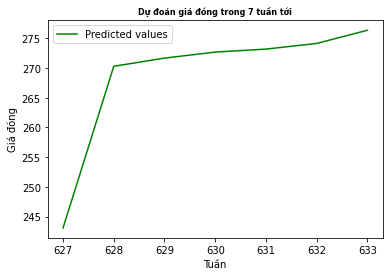

In [ ]:
plt.plot(df_netflix_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1 là giá đóng
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

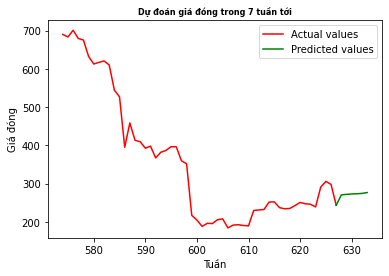

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_netflix_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_netflix_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1 là giá đóng
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

#### 6.2 Mô hình BiLSTM 

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_netflix,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional
def bilstm():
    regressor_bilstm = Sequential()
    # Input layer
    regressor_bilstm.add(Bidirectional(
              LSTM(units = 100), input_shape=(X_train.shape[1], X_train.shape[2])))
    regressor_bilstm.add(RepeatVector(6))
    # Hidden layer
    regressor_bilstm.add(Bidirectional(LSTM(units = 100, return_sequences = True)))
    regressor_bilstm.add(TimeDistributed(Dense(1)))
    #Compile model
    regressor_bilstm.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
    regressor_bilstm.summary()

    return regressor_bilstm

In [ ]:
regressor_bilstm = bilstm()
start_time=timer(None)
regressor_bilstm.fit( X_train, y_train, epochs = 5, batch_size = 32)
timer(start_time)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              85600     
 l)                                                              
                                                                 
 repeat_vector_3 (RepeatVect  (None, 6, 200)           0         
 or)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 6, 200)           240800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 6, 1)             201       
 tributed)                                                       
                                                                 
Total params: 326,601
Trainable params: 326,601
Non-tr

'0.0 giờ : 0.0 phút : 14.02 giây'

3/3 [==============================] - 2s 15ms/step
(65, 6, 1)


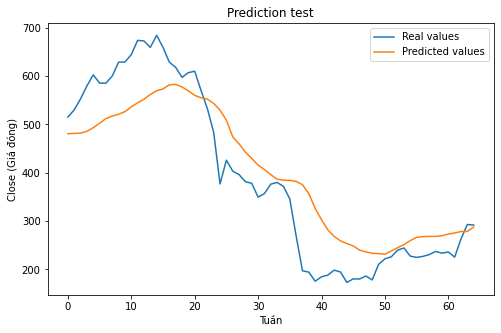

In [ ]:
#Test results
y_pred = regressor_bilstm.predict(X_test)
print(y_pred.shape) #(65, 6, 1) - reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_inv = sc.inverse_transform(y_test_inv)
y_pred_bilstm = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_inv[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_bilstm[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo và Vẽ đồ thị

In [ ]:
df_netflix_real_pred = data_netflix  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_netflix = df_netflix_real_pred.iloc[-time_step:]
  X_input = df_netflix.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1])) # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array

  biLSTM_prediction = regressor_bilstm.predict(X_input)
  biLSTM_prediction.shape
  biLSTM_prediction = np.reshape(biLSTM_prediction, (biLSTM_prediction.shape[0], 6)) #reshape (1, 1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  biLSTM_prediction = sc.inverse_transform(biLSTM_prediction)
  print("BiLSTM, Giá đóng cửa cho tuần " + str(week) +":", biLSTM_prediction[0,1])

  # Đưa dữ liệu vào bộ train
  df_netflix_predicted = pd.DataFrame(biLSTM_prediction, columns=df_netflix.columns)
  data = [df_netflix_real_pred, df_netflix_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_netflix_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_netflix_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_netflix_real_pred,training_set_scaled,
                                                  time_step, split_percent)
  # huấn luyện lại mô hình
  regressor_bilstm.fit(X_train, y_train, epochs = 5, batch_size = 32)


1/1 [==============================] - 0s 25ms/step
BiLSTM, Giá đóng cửa cho tuần 1: 325.9926
Epoch 1/5
16/16 [==============================] - 1s 79ms/step - loss: 0.0189 - mae: 0.0783
Epoch 2/5
16/16 [==============================] - 1s 81ms/step - loss: 0.0188 - mae: 0.0788
Epoch 3/5
16/16 [==============================] - 1s 79ms/step - loss: 0.0187 - mae: 0.0778
Epoch 4/5
16/16 [==============================] - 2s 131ms/step - loss: 0.0186 - mae: 0.0782
Epoch 5/5
1/1 [==============================] - 0s 27ms/step
BiLSTM, Giá đóng cửa cho tuần 2: 292.31244
Epoch 1/5
16/16 [==============================] - 1s 84ms/step - loss: 0.0187 - mae: 0.0784
Epoch 2/5
16/16 [==============================] - 1s 82ms/step - loss: 0.0186 - mae: 0.0770
Epoch 3/5
16/16 [==============================] - 1s 84ms/step - loss: 0.0185 - mae: 0.0773
Epoch 4/5
16/16 [==============================] - 1s 81ms/step - loss: 0.0186 - mae: 0.0775
Epoch 5/5
1/1 [==============================] - 0s 26ms

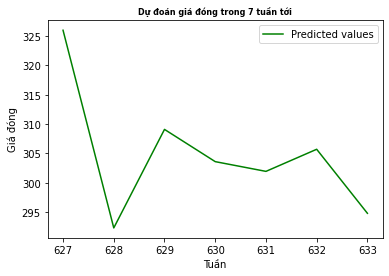

In [ ]:
plt.plot(df_netflix_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

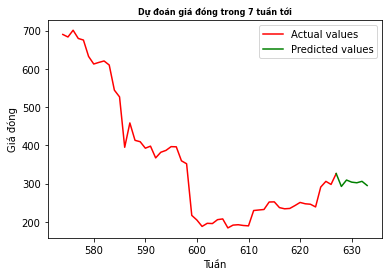

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_netflix_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_netflix_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

# **CỔ PHIẾU GOOGLE**

## Với bộ dữ liệu đã chuyển đổi thành tuần

### **(2) PHÂN TÍCH BÀI TOÁN**

Với giá của phiếu chúng ta sẽ chọn giá điều chỉnh, giá đóng, giá mở,... để dự đoán cho tương lai

In [ ]:
data_google = df_Google

In [ ]:
data_google.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-11-01,15.440724,15.689193,15.223190,15.442767,15.442767,554137286
2010-11-08,15.490886,15.712356,14.974123,15.416963,15.416963,501476639
2010-11-15,14.778805,15.043613,14.479975,14.695567,14.695567,566768455
2010-11-22,14.646663,14.859304,14.401021,14.689939,14.689939,323475940
2010-11-29,14.269514,14.689939,13.781095,14.181793,14.181793,759247218


In [ ]:
def split_sequences(data_stock, training_set_scaled, time_step, split_percent):
  split = int(split_percent*len(training_set_scaled)) #split percent multiplying by data rows

  X = []
  y = []
  for i in range(time_step + 1, len(training_set_scaled)):
    X.append(training_set_scaled[i-time_step-1:i-1, 0:len(data_stock.columns)]) #dung 60 tuần de du doan tuần thứ 61
    y.append(training_set_scaled[i,0:len(data_stock.columns)]) #lấy tất cả các cột vào set và trừ đi 2 cột

  X_arr, y_arr = np.array(X), np.array(y)

  #Split data
  X_train = X_arr[:split] #(80%) model train input data
  y_train = y_arr[:split] #80%) model train target data
  X_test = X_arr[split:] #(20%) test prediction input data
  y_test = y_arr[split:] #(20%) test prediction compare data

  #Reshaping lại rows/time_step/columns
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2])) #(samples, time-steps, features)
  y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1])) #(samples, time-steps, features)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) #(samples, time-steps, features)
  y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1])) #(samples, time-steps, features)

  return X_train, y_train, X_test, y_test

In [ ]:
future_prediction = 7 # 7 tuần
time_step = 60 #learning step: để giảm lỗi số của kết quả tính toán, giúp chia tập X,y
split_percent = 0.80 #train/test data split (80%)

In [ ]:
training_set = data_google.values 

# Normalize dữ liệu
sc = MinMaxScaler(feature_range = [0,1])
training_set_scaled = sc.fit_transform(training_set)

### **(3) XÂY DỰNG CÁC MÔ HÌNH**

In [ ]:
# Hàm tính thời gian train và test
def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        return str(thour) + " giờ : "+ str(tmin) +' phút : ' + str(round(tsec,2)) + ' giây' #hour:min:sec

#### 3.1 Mô hình RNN

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_google,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# RNN
def rnn():
  regressor_rnn = Sequential()
  regressor_rnn.add(SimpleRNN(units=100, activation='relu',
                        input_shape = (X_train.shape[1], X_train.shape[2])))
  regressor_rnn.add(RepeatVector(6))
  regressor_rnn.add(SimpleRNN(units=100, activation='relu', return_sequences = True))
  regressor_rnn.add(TimeDistributed(Dense(1))) # `TimeDistributed` Layer phải được chuyển qua `input_shape ` với ít nhât 3 dimen

  # Bien dich RNN
  regressor_rnn.compile(optimizer='adam', loss = 'mse', metrics=['mae'])#mean_squared_error
  regressor_rnn.summary()
  return regressor_rnn

In [ ]:
# huấn luyện mô hình
regressor_rnn = rnn()
start_time=timer(None)
history = regressor_rnn.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split=0.2, verbose=1)
mae = history.history['mae']
rnn_mae = round(float(mae[-1]), 5)
time_train_rnn = timer(start_time)
print('Training time -', timer(start_time))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 100)               10700     
                                                                 
 repeat_vector_4 (RepeatVect  (None, 6, 100)           0         
 or)                                                             
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 6, 100)            20100     
                                                                 
 time_distributed_4 (TimeDis  (None, 6, 1)             101       
 tributed)                                                       
                                                                 
Total params: 30,901
Trainable params: 30,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
13/13 [==============================] -

3/3 [==============================] - 0s 9ms/step
Testing time - 0.0 giờ : 0.0 phút : 0.32 giây
(65, 6, 1)


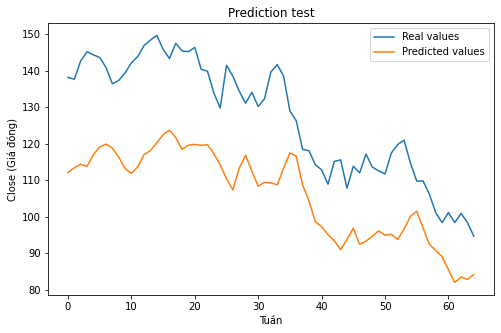

In [ ]:
start_time=timer(None)
#Test result
y_pred = regressor_rnn.predict(X_test)#verbose=1
print('Testing time -', timer(start_time))
time_test_rnn = timer(start_time)
print(y_pred.shape) #cần reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_rnn = sc.inverse_transform(y_test_inv)
y_pred_rnn = sc.inverse_transform(y_pred)


plt.figure(figsize=(8,5))
plt.plot(y_test_rnn[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo bằng RNN và Vẽ đồ thị

In [ ]:
df_google_real_pred = data_google # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_google = df_google_real_pred.iloc[-time_step:]
  X_input = df_google.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1])) # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array

  simple_RNN_prediction = regressor_rnn.predict(X_input) # dự đoán cho tuần thứ 61
  simple_RNN_prediction.shape
  simple_RNN_prediction = np.reshape(simple_RNN_prediction, (simple_RNN_prediction.shape[0], 6)) #reshapethành (1, 1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  simple_RNN_prediction = sc.inverse_transform(simple_RNN_prediction)
  print("Simple RNN, Giá đóng cửa cho tuần " + str(week) +":", simple_RNN_prediction[0,1])
  a= simple_RNN_prediction[0,1]
  # Đưa dữ liệu vào bộ train
  df_google_predicted = pd.DataFrame(simple_RNN_prediction, columns=df_google.columns)
  data = [df_google_real_pred, df_google_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_google_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_google_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_google_real_pred,training_set_scaled,
                                                  time_step, split_percent)
  # huấn luyện lại mô hình
  regressor_rnn.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split=0.2, verbose=1)


1/1 [==============================] - 0s 20ms/step
Simple RNN, Giá đóng cửa cho tuần 1: 98.62227
Epoch 1/5
13/13 [==============================] - 0s 23ms/step - loss: 0.0066 - mae: 0.0475 - val_loss: 0.0298 - val_mae: 0.1245
Epoch 2/5
13/13 [==============================] - 0s 24ms/step - loss: 0.0066 - mae: 0.0479 - val_loss: 0.0302 - val_mae: 0.1310
Epoch 3/5
13/13 [==============================] - 0s 21ms/step - loss: 0.0066 - mae: 0.0477 - val_loss: 0.0301 - val_mae: 0.1302
Epoch 4/5
13/13 [==============================] - 0s 20ms/step - loss: 0.0066 - mae: 0.0477 - val_loss: 0.0305 - val_mae: 0.1353
Epoch 5/5
1/1 [==============================] - 0s 22ms/step
Simple RNN, Giá đóng cửa cho tuần 2: 100.67347
Epoch 1/5
13/13 [==============================] - 0s 23ms/step - loss: 0.0066 - mae: 0.0481 - val_loss: 0.0297 - val_mae: 0.1188
Epoch 2/5
13/13 [==============================] - 0s 20ms/step - loss: 0.0066 - mae: 0.0489 - val_loss: 0.0309 - val_mae: 0.1396
Epoch 3/5
13/

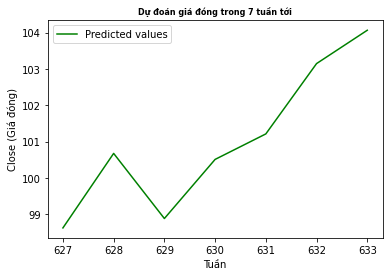

In [ ]:
plt.plot(df_google_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột Close price
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

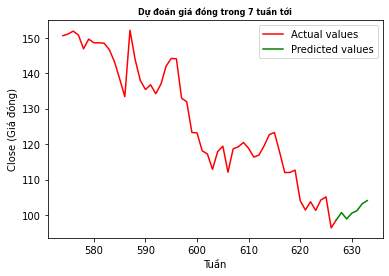

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_google_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_google_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột Close price
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

#### 3.2 Mô hình MLP

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_google,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train2 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train2 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
def mlp():
  regressor_mlp = Sequential()
  regressor_mlp.add(Dense(units=100, activation = "relu", input_dim=n_input))
  regressor_mlp.add(Dense(units=100, activation = "relu"))
  regressor_mlp.add(Dense(n_output))
  # Bien dich MLP
  regressor_mlp.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
  regressor_mlp.summary()
  return regressor_mlp

In [ ]:
# huấn luyện mô hình
regressor_mlp = mlp()
start_time=timer(None)
history = regressor_mlp.fit(X_train2, y_train2, epochs = 5, batch_size = 32, validation_split=0.2, verbose = 1)
mae = history.history['mae']
mlp_mae = round(float(mae[-1]), 5)
print('Training time -', timer(start_time))
time_train_mlp = timer(start_time)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 100)               36100     
                                                                 
 dense_12 (Dense)            (None, 100)               10100     
                                                                 
 dense_13 (Dense)            (None, 6)                 606       
                                                                 
Total params: 46,806
Trainable params: 46,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
13/13 [==============================] - 1s 15ms/step - loss: 0.0106 - mae: 0.0715 - val_loss: 0.0234 - val_mae: 0.1211
Epoch 2/5
13/13 [==============================] - 0s 5ms/step - loss: 0.0024 - mae: 0.0348 - val_loss: 0.0103 - val_mae: 0.0751
Epoch 3/5
13/13 [==============================] - 0s 5

3/3 [==============================] - 0s 3ms/step
Testing time - 0.0 giờ : 0.0 phút : 0.1 giây
(65, 6)


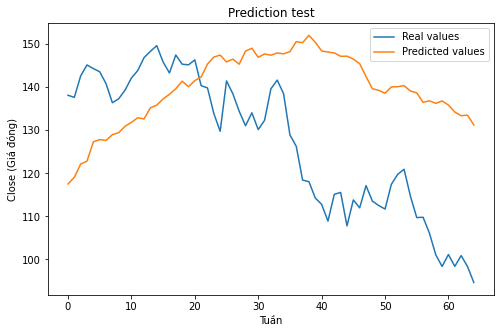

In [ ]:
X_test2 = X_test.reshape((X_test.shape[0], n_input))
start_time=timer(None)
#Test results
y_pred = regressor_mlp.predict(X_test2)
time_test_mlp = timer(start_time)
print('Testing time -', timer(start_time))
print(y_pred.shape) #(65, 6)

#Reshape dữ liệu cho inverse transforming
y_test2 = y_test.reshape((y_test.shape[0], n_output)) #reshape(65, 6)
# y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_mlp = sc.inverse_transform(y_test2)
y_pred_mlp = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_mlp[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo bằng MLP và Vẽ đồ thị

In [ ]:
df_google_real_pred = data_google  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán
week = 0
for i in range(future_prediction):
  week += 1
  df_google = df_google_real_pred.iloc[-time_step:]
  X_input = df_google.values
  X_input = sc.fit_transform(X_input) # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = X_input.reshape(1, n_input) # 1 phần tử chứa 540 

  mlp_prediction = regressor_mlp.predict(X_input)
  mlp_prediction = np.reshape(mlp_prediction, (mlp_prediction.shape[0], 6)) #reshape (1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  mlp_prediction = sc.inverse_transform(mlp_prediction)
  print("MLP, Giá đóng cửa cho tuần " + str(week) +":", mlp_prediction[0,1])
  
  # Đưa dữ liệu vào bộ train
  df_google_predicted = pd.DataFrame(mlp_prediction, columns=df_google.columns)
  data = [df_google_real_pred, df_google_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_google_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_google_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_google_real_pred,training_set_scaled,
                                                  time_step, split_percent)

  # flatten input
  n_input = X_train.shape[1] * X_train.shape[2]
  X_train2 = X_train.reshape((X_train.shape[0], n_input))
  n_output = y_train.shape[2]
  y_train2 = y_train.reshape((y_train.shape[0], n_output))

  # huấn luyện lại mô hình
  regressor_mlp.fit(X_train2, y_train2, epochs = 5, batch_size = 32, validation_split=0.2, verbose= 1)


1/1 [==============================] - 0s 18ms/step
MLP, Giá đóng cửa cho tuần 1: 123.6904
Epoch 1/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0014 - mae: 0.0234 - val_loss: 0.0088 - val_mae: 0.0719
Epoch 2/5
13/13 [==============================] - 0s 5ms/step - loss: 0.0013 - mae: 0.0226 - val_loss: 0.0096 - val_mae: 0.0769
Epoch 3/5
13/13 [==============================] - 0s 6ms/step - loss: 0.0013 - mae: 0.0226 - val_loss: 0.0075 - val_mae: 0.0660
Epoch 4/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0013 - mae: 0.0217 - val_loss: 0.0076 - val_mae: 0.0666
Epoch 5/5
1/1 [==============================] - 0s 19ms/step
MLP, Giá đóng cửa cho tuần 2: 118.049805
Epoch 1/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0011 - mae: 0.0201 - val_loss: 0.0088 - val_mae: 0.0733
Epoch 2/5
13/13 [==============================] - 0s 5ms/step - loss: 0.0011 - mae: 0.0206 - val_loss: 0.0078 - val_mae: 0.0693
Epoch 3/5
13/13 [===============

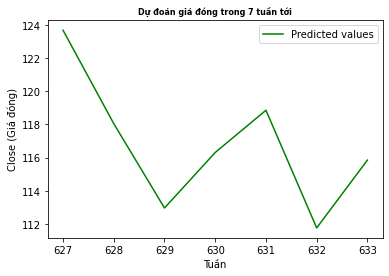

In [ ]:
plt.plot(df_google_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

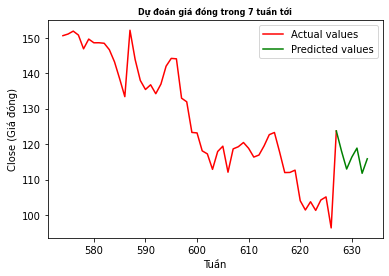

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_google_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_google_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

#### 3.3 Mô hình Random Forest

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_google,training_set_scaled,
                                                  time_step, split_percent)
# (2416, 60, 6), (2416, 1, 6), (65, 60, 6), (65, 1, 6)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2] 
X_train3 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train3 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor() # không parameter để test overfitting
start_time=timer(None)
regressor_rf.fit(X_train3, y_train3)
time_train_rf = timer(start_time)
print('Training time -', timer(start_time))

Training time - 0.0 giờ : 0.0 phút : 7.57 giây


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
X_test3 = X_test.reshape((X_test.shape[0], n_input))
y_test3 = y_test.reshape((y_test.shape[0], n_output))
#Test results
start_time=timer(None)
y_pred = regressor_rf.predict(X_test3)
time_test_rf = timer(start_time)
rf_mae = mean_absolute_error(y_test3, y_pred)
print('Testing time -', timer(start_time))
print('Mean Absolute Error:', rf_mae)
print('Mean Squared Error:', mean_squared_error(y_test3, y_pred))

Testing time - 0.0 giờ : 0.0 phút : 0.02 giây
Mean Absolute Error: 0.0854654134968391
Mean Squared Error: 0.011524441822426387


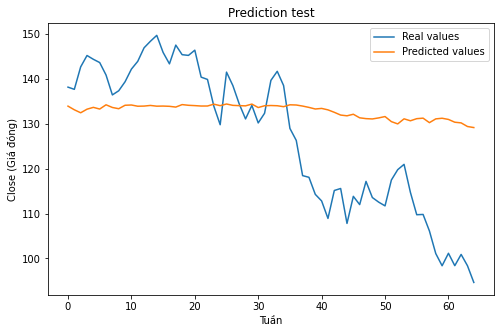

In [ ]:
#Reversing transform để có được giá trị dữ liệu thích hợp
y_test_rf = sc.inverse_transform(y_test3)
y_pred_rf = sc.inverse_transform(y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_test_rf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo bằng Random Forest và Vẽ đồ thị

In [ ]:
df_google_real_pred = data_google  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
df_google_real_pred.shape

(627, 6)

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_google_pred = df_google_real_pred.iloc[-time_step:]
  X_input = df_google_pred.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = X_input.reshape(1, n_input) # 1 phần tử chứa 540 # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array
  print(X_input.shape)
  rf_prediction = regressor_rf.predict(X_input)
  # y_pred = regressor_rf.predict(X_test3)
  rf_prediction = np.reshape(rf_prediction, (rf_prediction.shape[0], 6)) #reshaping for (1, 6)
   #inverse transform để có được giá trị dữ liệu phù hợp
  rf_prediction = sc.inverse_transform(rf_prediction)
  print("Random Forest, Giá đóng cho tuần " + str(week) +":", rf_prediction[0,1])
  
  # Đưa dữ liệu vào bộ train
  df_google_predicted = pd.DataFrame(rf_prediction, columns=df_google.columns)
  data = [df_google_real_pred, df_google_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_google_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_google_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_google_real_pred,training_set_scaled,
                                                  time_step, split_percent)

  # flatten input
  n_input = X_train.shape[1] * X_train.shape[2]
  X_train3 = X_train.reshape((X_train.shape[0], n_input))
  n_output = y_train.shape[2]
  y_train3 = y_train.reshape((y_train.shape[0], n_output))

  # huấn luyện lại mô hình
  regressor_rf.fit(X_train3, y_train3)


(1, 360)
Random Forest, Giá đóng cho tuần 1: 113.531294820954
(1, 360)
Random Forest, Giá đóng cho tuần 2: 114.14476115407871
(1, 360)
Random Forest, Giá đóng cho tuần 3: 114.9698278273275
(1, 360)
Random Forest, Giá đóng cho tuần 4: 115.97824065401751
(1, 360)
Random Forest, Giá đóng cho tuần 5: 116.57397788343062
(1, 360)
Random Forest, Giá đóng cho tuần 6: 115.59682275250515
(1, 360)
Random Forest, Giá đóng cho tuần 7: 116.05065115465707


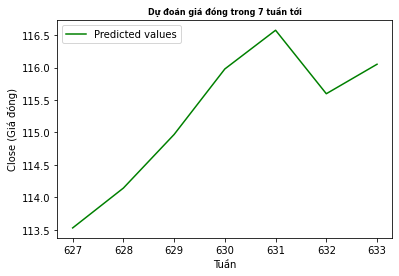

In [ ]:
plt.plot(df_google_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

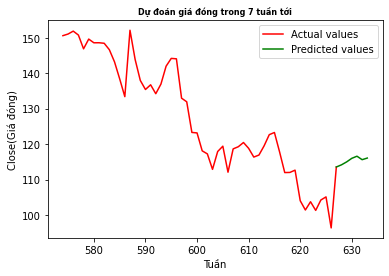

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_google_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_google_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close(Giá đóng)")
plt.legend()

#### 3.4 Đánh giá độ đo MAE và so sánh

In [ ]:
compare = pd.DataFrame({'Model': ['RNN', 'MLP', 'Random Forest'], 
                        'Mean Absolute Error': [rnn_mae, mlp_mae, rf_mae]})
compare.sort_values(by='Mean Absolute Error', ascending=True)

,Model,Mean Absolute Error
1,MLP,0.024120
0,RNN,0.046900
2,Random Forest,0.085465


#### 3.5 Thời gian Training và Testing

In [ ]:
compare = pd.DataFrame({'Model': ['RNN', 'MLP', 'Random Forest'], 
                        'Training time': [time_train_rnn, time_train_mlp,  time_train_rf]})
compare.sort_values(by='Training time', ascending=True)

,Model,Training time
1,MLP,0.0 giờ : 0.0 phút : 0.96 giây
0,RNN,0.0 giờ : 0.0 phút : 3.3 giây
2,Random Forest,0.0 giờ : 0.0 phút : 7.57 giây


In [ ]:
compare = pd.DataFrame({'Model': ['RNN', 'MLP', 'Random Forest'], 
                        'Testing time': [time_test_rnn, time_test_mlp,  time_test_rf]})
compare.sort_values(by='Testing time', ascending=True)

,Model,Testing time
2,Random Forest,0.0 giờ : 0.0 phút : 0.02 giây
1,MLP,0.0 giờ : 0.0 phút : 0.1 giây
0,RNN,0.0 giờ : 0.0 phút : 0.32 giây


###(4) XỬ LÝ OVERFITTING VÀ SO SÁNH

In [ ]:
early_stopping = EarlyStopping(patience=2, min_delta=0.0001, monitor="val_loss", verbose=1)

#### 4.1 Mô hình RNN

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_google,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
regressor_rnn = Sequential()
regressor_rnn.add(SimpleRNN(units=100, activation='relu',
                        input_shape = (X_train.shape[1], X_train.shape[2])))
regressor_rnn.add(Dropout(0.2))
regressor_rnn.add(RepeatVector(6))
regressor_rnn.add(SimpleRNN(units=100, activation='relu', return_sequences = True))
regressor_rnn.add(Dropout(0.2))
regressor_rnn.add(TimeDistributed(Dense(1))) # `TimeDistributed` Layer phải được chuyển qua `input_shape ` với ít nhât 3 dimen

# Bien dich RNN
regressor_rnn.compile(optimizer='adam', loss = 'mse', metrics=['mae'])#mean_squared_error
regressor_rnn.summary()

# huấn luyện mô hình RNN đã dropout với early stopping
regressor_rnn.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split=0.2, callbacks=[early_stopping],verbose=1)
# callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]) validation_split=0.2 verbose=1

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 100)               10700     
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 repeat_vector_5 (RepeatVect  (None, 6, 100)           0         
 or)                                                             
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 6, 100)            20100     
                                                                 
 dropout_7 (Dropout)         (None, 6, 100)            0         
                                                                 
 time_distributed_5 (TimeDis  (None, 6, 1)             101       
 tributed)                                            

3/3 [==============================] - 0s 7ms/step
(65, 6, 1)


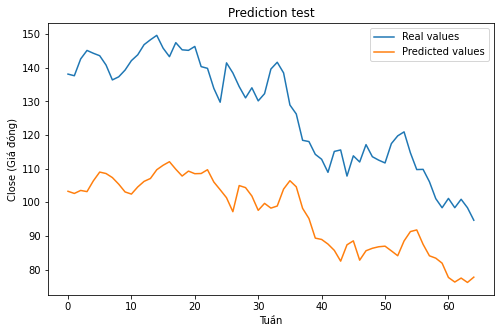

In [ ]:
#Test results
y_pred = regressor_rnn.predict(X_test)#verbose=1
print(y_pred.shape) #cần reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_rnn_ovf = sc.inverse_transform(y_test_inv)
y_pred_rnn_ovf = sc.inverse_transform(y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_test_rnn_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

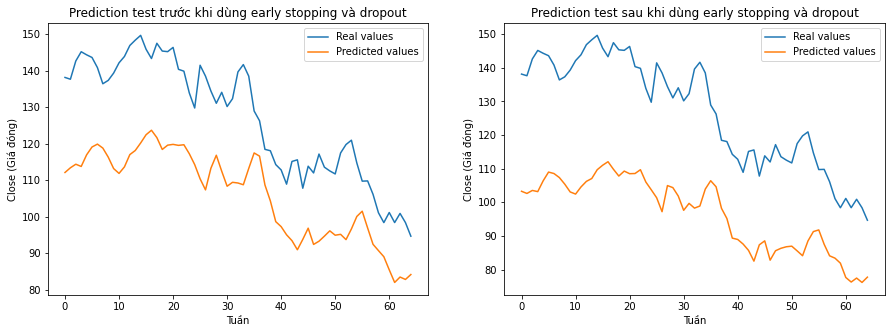

In [ ]:
# so sánh trước và sau khi xử lý overfiting
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(y_test_rnn[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test trước khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(y_test_rnn_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test sau khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

#### 4.2 Mô hình MLP

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_google,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train2 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train2 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
regressor_mlp = Sequential()
regressor_mlp.add(Dense(units=100, activation = "relu", input_dim=n_input))
regressor_mlp.add(Dropout(0.2))
regressor_mlp.add(Dense(units=100, activation = "relu"))
regressor_mlp.add(Dropout(0.2))
regressor_mlp.add(Dense(n_output))
# Bien dich MLP
regressor_mlp.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
regressor_mlp.summary()
# huấn luyện mô hình
regressor_mlp.fit(X_train2, y_train2, epochs = 5, batch_size = 32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               36100     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 6)                 606       
                                                                 
Total params: 46,806
Trainable params: 46,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
13/13 [==============================] -

3/3 [==============================] - 0s 3ms/step
(65, 6)


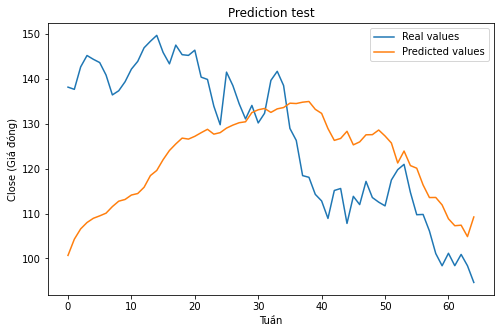

In [ ]:
# regressor.fit(X_train2, y_train, epochs = 5, batch_size = 32)
X_test2 = X_test.reshape((X_test.shape[0], n_input))

#Test results
y_pred = regressor_mlp.predict(X_test2)
print(y_pred.shape) #(65, 6)

#Reshape dữ liệu cho inverse transforming
y_test2 = y_test.reshape((y_test.shape[0], n_output)) #reshape (65, 6)
# y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_mlp_ovf = sc.inverse_transform(y_test2)
y_pred_mlp_ovf = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_mlp_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

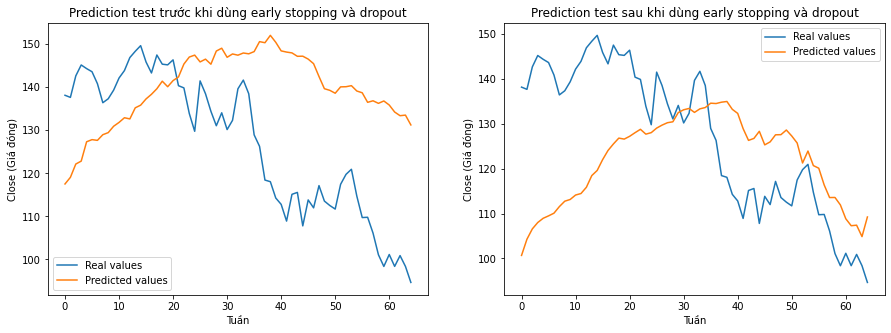

In [ ]:
# so sánh trước và sau khi xử lý overfiting
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(y_test_mlp[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test trước khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(y_test_mlp_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test sau khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

#### 4.3 Mô hình Random forest

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_google,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train3 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train3 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
# Tìm tham số tốt nhất để xử lý overfitting
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 5 , stop = 15, num = 10)] # returns 10 numbers 

max_features = ['auto', 'log2']

max_depth = [int(x) for x in np.linspace(5, 10, num = 2)] 

max_depth.append(None)

bootstrap = [True, False]

r_grid = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'bootstrap': bootstrap}
          
rfr = RandomForestRegressor(random_state = 1)

rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=r_grid, n_iter = 20, 
                                scoring='neg_mean_absolute_error', cv = 3, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)

rfr_random.fit(X_train3, y_train3)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, None],
                                        'max_features': ['auto', 'log2'],
                                        'n_estimators': [5, 6, 7, 8, 9, 10, 11,
                                                         12, 13, 15]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print(rfr_random.best_params_)

{'n_estimators': 5, 'max_features': 'log2', 'max_depth': 5, 'bootstrap': True}


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# có thể sử dụng nhiều tham số để loại bỏ phần thừa một cách dễ dàng
regressor_rf = RandomForestRegressor(n_estimators= 10, max_features= 'log2', 
                                     max_depth= 5, bootstrap= True) 
regressor_rf.fit(X_train3, y_train3)

RandomForestRegressor(max_depth=5, max_features='log2', n_estimators=10)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
X_test3 = X_test.reshape((X_test.shape[0], n_input))
y_test3 = y_test.reshape((y_test.shape[0], n_output)) # (65, 1, 6) -> (65, 6)
#Test results
y_pred = regressor_rf.predict(X_test3)
print('Mean Absolute Error:', mean_absolute_error(y_test3, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test3, y_pred))

Mean Absolute Error: 0.08108376998012178
Mean Squared Error: 0.010152098820936165


In [ ]:
y_test.shape

(65, 1, 6)

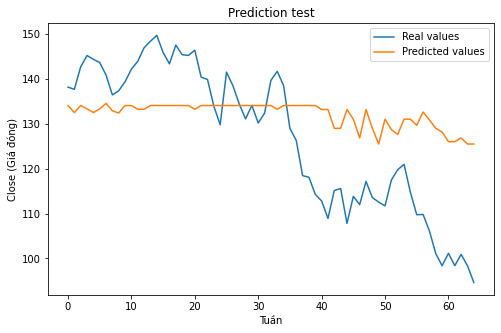

In [ ]:
#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_rf_ovf = sc.inverse_transform(y_test3)
y_pred_rf_ovf = sc.inverse_transform(y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_test_rf_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

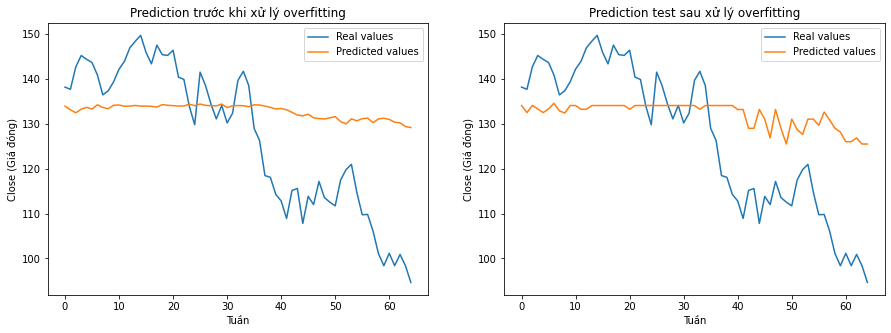

In [ ]:
# so sánh trước và sau khi xử lý overfiting
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(y_test_rf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction trước khi xử lý overfitting')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(y_test_rf_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test sau xử lý overfitting')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

###(5) TÌM ĐẶC TRƯNG QUAN TRỌNG NHẤT

In [ ]:
# Feature selection bằng ExtraTreesRegressor(dựa trên mô hình)
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc

In [ ]:
df_google = df_google
X = df_google.drop(['Close'], axis=1)
y = df_google['Close']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [ ]:
reg= ExtraTreesRegressor()
reg.fit(X_train,y_train)

ExtraTreesRegressor()

In [ ]:
reg.feature_importances_

array([0.2842874 , 0.35473566, 0.16118665, 0.19768553, 0.00210475])

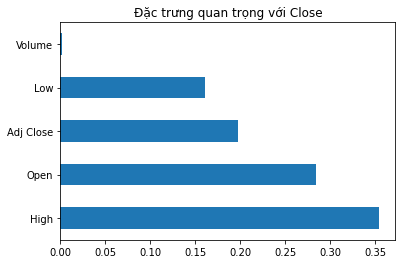

In [ ]:
feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh', title='Đặc trưng quan trọng với Close')
plt.show()

In [ ]:
feat_importances

Open         0.284287
High         0.354736
Low          0.161187
Adj Close    0.197686
Volume       0.002105
dtype: float64

In [ ]:
feat_importances[feat_importances == max(feat_importances)].index

Index(['High'], dtype='object')

### (6) MÔ HÌNH DEEP LEARNING

#### 6.1 Mô hình LSTM

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_google,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# LSTM
def lstm():
  regressor_lstm = Sequential()
  regressor_lstm.add(LSTM(units=100,input_shape = (X_train.shape[1], X_train.shape[2])))
  regressor_lstm.add(Dropout(0.2))
  regressor_lstm.add(RepeatVector(6))
  regressor_lstm.add(LSTM(units=100, return_sequences = True))
  regressor_lstm.add(Dropout(0.2))
  regressor_lstm.add(TimeDistributed(Dense(1))) # `TimeDistributed` Layer phải được chuyển qua `input_shape ` với ít nhât 3 dimen

  # Bien dich LSTM
  regressor_lstm.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
  regressor_lstm.summary()
  return regressor_lstm

In [ ]:
# huấn luyện mô hình
regressor_lstm = lstm()
regressor_lstm.fit(X_train, y_train, epochs = 5, batch_size = 32,  shuffle = False)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100)               42800     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 repeat_vector_6 (RepeatVect  (None, 6, 100)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 6, 100)            80400     
                                                                 
 dropout_11 (Dropout)        (None, 6, 100)            0         
                                                                 
 time_distributed_6 (TimeDis  (None, 6, 1)             101       
 tributed)                                           

3/3 [==============================] - 2s 15ms/step
(65, 6, 1)


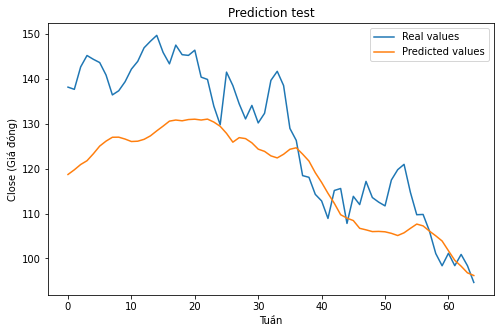

In [ ]:
#Test results
y_pred = regressor_lstm.predict(X_test)
print(y_pred.shape) #(65, 6, 1)  reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_inv = sc.inverse_transform(y_test_inv)
y_pred_lstm = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_inv[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_lstm[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán "
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo và Vẽ đồ thị

In [ ]:
df_google_real_pred = data_google  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_google = df_google_real_pred.iloc[-time_step:]
  X_input = df_google.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1])) # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array

  LSTM_prediction = regressor_lstm.predict(X_input) # dự đoán cho tuần thứ 61
  LSTM_prediction.shape
  LSTM_prediction = np.reshape(LSTM_prediction, (LSTM_prediction.shape[0], 6)) #reshaping for (1, 1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  LSTM_prediction = sc.inverse_transform(LSTM_prediction)
  print("LSTM, Giá đóng cửa cho tuần " + str(week) +":", LSTM_prediction[0,1])

  # Đưa dữ liệu vào bộ train
  df_google_predicted = pd.DataFrame(LSTM_prediction, columns=df_google.columns)
  data = [df_google_real_pred, df_google_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_google_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_google_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_google_real_pred,training_set_scaled,
                                                  time_step, split_percent)
  # huấn luyện lại mô hình
  regressor_lstm.fit(X_train, y_train, epochs = 5, batch_size = 32)


1/1 [==============================] - 0s 35ms/step
LSTM, Giá đóng cửa cho tuần 1: 104.17195
Epoch 1/5
16/16 [==============================] - 2s 117ms/step - loss: 0.0140 - mae: 0.0761
Epoch 2/5
16/16 [==============================] - 1s 85ms/step - loss: 0.0128 - mae: 0.0704
Epoch 3/5
16/16 [==============================] - 1s 78ms/step - loss: 0.0124 - mae: 0.0671
Epoch 4/5
16/16 [==============================] - 1s 79ms/step - loss: 0.0124 - mae: 0.0659
Epoch 5/5
1/1 [==============================] - 0s 22ms/step
LSTM, Giá đóng cửa cho tuần 2: 103.86663
Epoch 1/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0120 - mae: 0.0652
Epoch 2/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0121 - mae: 0.0653
Epoch 3/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0119 - mae: 0.0652
Epoch 4/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0120 - mae: 0.0659
Epoch 5/5
1/1 [==============================] - 0s 24ms/st

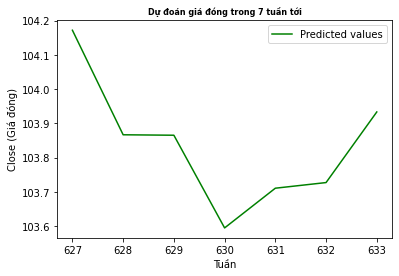

In [ ]:
plt.plot(df_google_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1 là giá đóng
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

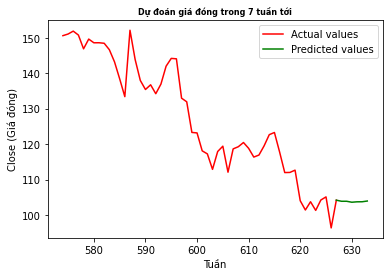

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_google_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_google_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1 là giá đóng
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

#### 6.2 Mô hình BiLSTM 

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_google,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional
def bilstm():
    regressor_bilstm = Sequential()
    # Input layer
    regressor_bilstm.add(Bidirectional(
              LSTM(units = 100), input_shape=(X_train.shape[1], X_train.shape[2])))
    regressor_bilstm.add(RepeatVector(6))
    # Hidden layer
    regressor_bilstm.add(Bidirectional(LSTM(units = 100, return_sequences = True)))
    regressor_bilstm.add(TimeDistributed(Dense(1)))
    #Compile model
    regressor_bilstm.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
    regressor_bilstm.summary()

    return regressor_bilstm

In [ ]:
regressor_bilstm = bilstm()
start_time=timer(None)
regressor_bilstm.fit( X_train, y_train, epochs = 5, batch_size = 32)
timer(start_time)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 200)              85600     
 nal)                                                            
                                                                 
 repeat_vector_7 (RepeatVect  (None, 6, 200)           0         
 or)                                                             
                                                                 
 bidirectional_3 (Bidirectio  (None, 6, 200)           240800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 6, 1)             201       
 tributed)                                                       
                                                                 
Total params: 326,601
Trainable params: 326,601
Non-t

'0.0 giờ : 0.0 phút : 14.35 giây'

3/3 [==============================] - 3s 29ms/step
(65, 6, 1)


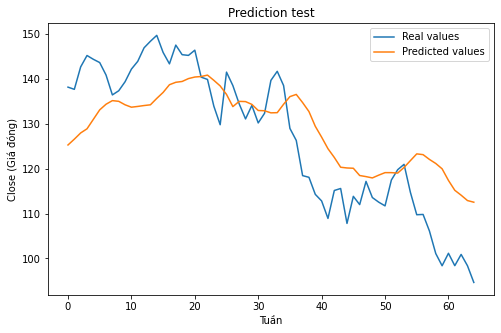

In [ ]:
#Test results
y_pred = regressor_bilstm.predict(X_test)
print(y_pred.shape) #(65, 6, 1) - reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_inv = sc.inverse_transform(y_test_inv)
y_pred_bilstm = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_inv[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_bilstm[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo và Vẽ đồ thị

In [ ]:
df_google_real_pred = data_google  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_google = df_google_real_pred.iloc[-time_step:]
  X_input = df_google.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1])) # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array

  biLSTM_prediction = regressor_bilstm.predict(X_input)
  biLSTM_prediction.shape
  biLSTM_prediction = np.reshape(biLSTM_prediction, (biLSTM_prediction.shape[0], 6)) #reshape (1, 1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  biLSTM_prediction = sc.inverse_transform(biLSTM_prediction)
  print("BiLSTM, Giá đóng cửa cho tuần " + str(week) +":", biLSTM_prediction[0,1])

  # Đưa dữ liệu vào bộ train
  df_google_predicted = pd.DataFrame(biLSTM_prediction, columns=df_google.columns)
  data = [df_google_real_pred, df_google_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_google_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_google_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_google_real_pred,training_set_scaled,
                                                  time_step, split_percent)
  # huấn luyện lại mô hình
  regressor_bilstm.fit(X_train, y_train, epochs = 5, batch_size = 32)


1/1 [==============================] - 0s 28ms/step
BiLSTM, Giá đóng cửa cho tuần 1: 109.760544
Epoch 1/5
16/16 [==============================] - 1s 83ms/step - loss: 0.0115 - mae: 0.0638
Epoch 2/5
16/16 [==============================] - 1s 82ms/step - loss: 0.0115 - mae: 0.0638
Epoch 3/5
16/16 [==============================] - 1s 85ms/step - loss: 0.0114 - mae: 0.0623
Epoch 4/5
16/16 [==============================] - 1s 81ms/step - loss: 0.0114 - mae: 0.0634
Epoch 5/5
1/1 [==============================] - 0s 29ms/step
BiLSTM, Giá đóng cửa cho tuần 2: 107.999626
Epoch 1/5
16/16 [==============================] - 1s 79ms/step - loss: 0.0113 - mae: 0.0629
Epoch 2/5
16/16 [==============================] - 1s 79ms/step - loss: 0.0114 - mae: 0.0623
Epoch 3/5
16/16 [==============================] - 1s 81ms/step - loss: 0.0113 - mae: 0.0627
Epoch 4/5
16/16 [==============================] - 1s 79ms/step - loss: 0.0113 - mae: 0.0627
Epoch 5/5
1/1 [==============================] - 0s 29

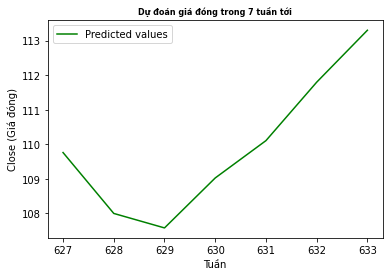

In [ ]:
plt.plot(df_google_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

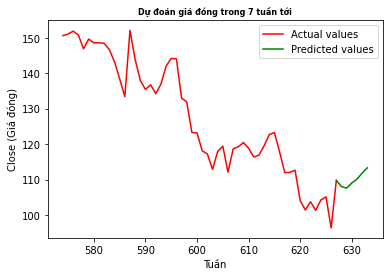

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_google_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_google_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

# **CỔ PHIẾU APPLE**

## Với bộ dữ liệu đã chuyển đổi thành tuần

### **(2) PHÂN TÍCH BÀI TOÁN**

Với giá của phiếu chúng ta sẽ chọn giá điều chỉnh, giá đóng, giá mở,... để dự đoán cho tương lai

In [ ]:
data_apple = df_Apple

In [ ]:
data_apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-11-01,11.100214,11.435000,10.792857,11.155286,9.508964,2369908800
2010-11-08,11.327785,11.475000,10.843929,11.267214,9.604375,2206660400
2010-11-15,10.918214,11.090714,10.634286,10.887786,9.280943,2420040000
2010-11-22,11.097053,11.346429,10.923929,11.177589,9.527978,1563833600
2010-11-29,11.277500,11.392857,11.102500,11.285786,9.620206,2214324000


In [ ]:
def split_sequences(data_stock, training_set_scaled, time_step, split_percent):
  split = int(split_percent*len(training_set_scaled)) #split percent multiplying by data rows

  X = []
  y = []
  for i in range(time_step + 1, len(training_set_scaled)):
    X.append(training_set_scaled[i-time_step-1:i-1, 0:len(data_stock.columns)]) #dung 60 tuần de du doan tuần thứ 61
    y.append(training_set_scaled[i,0:len(data_stock.columns)]) #lấy tất cả các cột vào set và trừ đi 2 cột

  X_arr, y_arr = np.array(X), np.array(y)

  #Split data
  X_train = X_arr[:split] #(80%) model train input data
  y_train = y_arr[:split] #80%) model train target data
  X_test = X_arr[split:] #(20%) test prediction input data
  y_test = y_arr[split:] #(20%) test prediction compare data

  #Reshaping lại rows/time_step/columns
  X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2])) #(samples, time-steps, features)
  y_train = np.reshape(y_train, (y_train.shape[0], 1, y_train.shape[1])) #(samples, time-steps, features)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2])) #(samples, time-steps, features)
  y_test = np.reshape(y_test, (y_test.shape[0], 1, y_test.shape[1])) #(samples, time-steps, features)

  return X_train, y_train, X_test, y_test

In [ ]:
future_prediction = 7 # 7 tuần
time_step = 60 #learning step: để giảm lỗi số của kết quả tính toán, giúp chia tập X,y
split_percent = 0.80 #train/test data split (80%)

In [ ]:
training_set = data_apple.values 

# Normalize dữ liệu
sc = MinMaxScaler(feature_range = [0,1])
training_set_scaled = sc.fit_transform(training_set)

### **(3) XÂY DỰNG CÁC MÔ HÌNH**

In [ ]:
# Hàm tính thời gian train và test
def timer(start_time=None):
    if not start_time:
        start_time=datetime.now()
        return start_time
    elif start_time:
        thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
        tmin,tsec=divmod(temp_sec,60)
        return str(thour) + " giờ : "+ str(tmin) +' phút : ' + str(round(tsec,2)) + ' giây' #hour:min:sec

#### 3.1 Mô hình RNN

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_apple,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# RNN
def rnn():
  regressor_rnn = Sequential()
  regressor_rnn.add(SimpleRNN(units=100, activation='relu',
                        input_shape = (X_train.shape[1], X_train.shape[2])))
  regressor_rnn.add(RepeatVector(6))
  regressor_rnn.add(SimpleRNN(units=100, activation='relu', return_sequences = True))
  regressor_rnn.add(TimeDistributed(Dense(1))) # `TimeDistributed` Layer phải được chuyển qua `input_shape ` với ít nhât 3 dimen

  # Bien dich RNN
  regressor_rnn.compile(optimizer='adam', loss = 'mse', metrics=['mae'])#mean_squared_error
  regressor_rnn.summary()
  return regressor_rnn

In [ ]:
# huấn luyện mô hình
regressor_rnn = rnn()
start_time=timer(None)
history = regressor_rnn.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split=0.2, verbose=1)
mae = history.history['mae']
rnn_mae = round(float(mae[-1]), 5)
time_train_rnn = timer(start_time)
print('Training time -', timer(start_time))

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 100)               10700     
                                                                 
 repeat_vector_8 (RepeatVect  (None, 6, 100)           0         
 or)                                                             
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 6, 100)            20100     
                                                                 
 time_distributed_8 (TimeDis  (None, 6, 1)             101       
 tributed)                                                       
                                                                 
Total params: 30,901
Trainable params: 30,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
13/13 [==============================] 

3/3 [==============================] - 0s 7ms/step
Testing time - 0.0 giờ : 0.0 phút : 0.3 giây
(65, 6, 1)


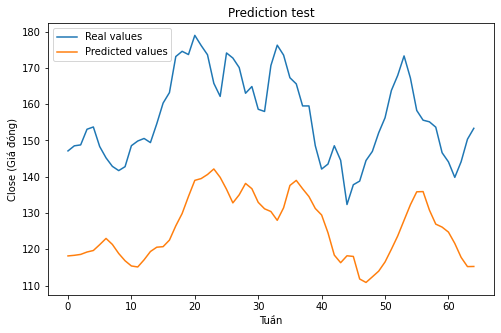

In [ ]:
start_time=timer(None)
#Test result
y_pred = regressor_rnn.predict(X_test)#verbose=1
print('Testing time -', timer(start_time))
time_test_rnn = timer(start_time)
print(y_pred.shape) #cần reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_rnn = sc.inverse_transform(y_test_inv)
y_pred_rnn = sc.inverse_transform(y_pred)


plt.figure(figsize=(8,5))
plt.plot(y_test_rnn[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo bằng RNN và Vẽ đồ thị

In [ ]:
df_apple_real_pred = data_apple # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_apple = df_apple_real_pred.iloc[-time_step:]
  X_input = df_apple.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1])) # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array

  simple_RNN_prediction = regressor_rnn.predict(X_input) # dự đoán cho tuần thứ 61
  simple_RNN_prediction.shape
  simple_RNN_prediction = np.reshape(simple_RNN_prediction, (simple_RNN_prediction.shape[0], 6)) #reshapethành (1, 1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  simple_RNN_prediction = sc.inverse_transform(simple_RNN_prediction)
  print("Simple RNN, Giá đóng cửa cho tuần " + str(week) +":", simple_RNN_prediction[0,1])
  a= simple_RNN_prediction[0,1]
  # Đưa dữ liệu vào bộ train
  df_apple_predicted = pd.DataFrame(simple_RNN_prediction, columns=df_apple.columns)
  data = [df_apple_real_pred, df_apple_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_apple_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_apple_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_apple_real_pred,training_set_scaled,
                                                  time_step, split_percent)
  # huấn luyện lại mô hình
  regressor_rnn.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split=0.2, verbose=1)


1/1 [==============================] - 0s 19ms/step
Simple RNN, Giá đóng cửa cho tuần 1: 152.91512
Epoch 1/5
13/13 [==============================] - 0s 25ms/step - loss: 0.0087 - mae: 0.0497 - val_loss: 0.0323 - val_mae: 0.1385
Epoch 2/5
13/13 [==============================] - 1s 60ms/step - loss: 0.0087 - mae: 0.0495 - val_loss: 0.0331 - val_mae: 0.1458
Epoch 3/5
13/13 [==============================] - 0s 19ms/step - loss: 0.0087 - mae: 0.0504 - val_loss: 0.0326 - val_mae: 0.1416
Epoch 4/5
13/13 [==============================] - 0s 19ms/step - loss: 0.0087 - mae: 0.0499 - val_loss: 0.0322 - val_mae: 0.1380
Epoch 5/5
1/1 [==============================] - 0s 23ms/step
Simple RNN, Giá đóng cửa cho tuần 2: 152.53827
Epoch 1/5
13/13 [==============================] - 0s 24ms/step - loss: 0.0087 - mae: 0.0499 - val_loss: 0.0317 - val_mae: 0.1315
Epoch 2/5
13/13 [==============================] - 0s 19ms/step - loss: 0.0087 - mae: 0.0494 - val_loss: 0.0318 - val_mae: 0.1337
Epoch 3/5
13

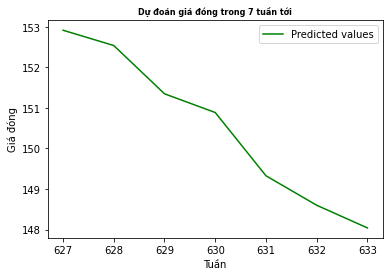

In [ ]:
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột Close price
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

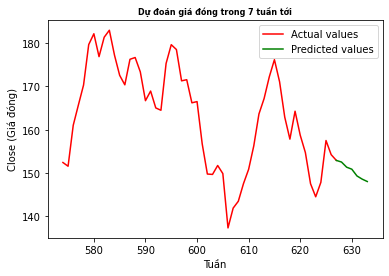

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_apple_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột Close price
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Close (Giá đóng)")
plt.legend()

#### 3.2 Mô hình MLP

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_apple,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train2 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train2 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
def mlp():
  regressor_mlp = Sequential()
  regressor_mlp.add(Dense(units=100, activation = "relu", input_dim=n_input))
  regressor_mlp.add(Dense(units=100, activation = "relu"))
  regressor_mlp.add(Dense(n_output))
  # Bien dich MLP
  regressor_mlp.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
  regressor_mlp.summary()
  return regressor_mlp

In [ ]:
# huấn luyện mô hình
regressor_mlp = mlp()
start_time=timer(None)
history = regressor_mlp.fit(X_train2, y_train2, epochs = 5, batch_size = 32, validation_split=0.2, verbose = 1)
mae = history.history['mae']
mlp_mae = round(float(mae[-1]), 5)
print('Training time -', timer(start_time))
time_train_mlp = timer(start_time)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 100)               36100     
                                                                 
 dense_22 (Dense)            (None, 100)               10100     
                                                                 
 dense_23 (Dense)            (None, 6)                 606       
                                                                 
Total params: 46,806
Trainable params: 46,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
13/13 [==============================] - 1s 19ms/step - loss: 0.0195 - mae: 0.0926 - val_loss: 0.0316 - val_mae: 0.1480
Epoch 2/5
13/13 [==============================] - 0s 5ms/step - loss: 0.0042 - mae: 0.0448 - val_loss: 0.0191 - val_mae: 0.1161
Epoch 3/5
13/13 [==============================] - 0s 

3/3 [==============================] - 0s 4ms/step
Testing time - 0.0 giờ : 0.0 phút : 0.11 giây
(65, 6)


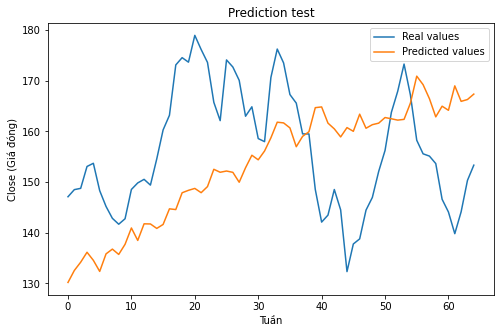

In [ ]:
X_test2 = X_test.reshape((X_test.shape[0], n_input))
start_time=timer(None)
#Test results
y_pred = regressor_mlp.predict(X_test2)
time_test_mlp = timer(start_time)
print('Testing time -', timer(start_time))
print(y_pred.shape) #(65, 6)

#Reshape dữ liệu cho inverse transforming
y_test2 = y_test.reshape((y_test.shape[0], n_output)) #reshape(65, 6)
# y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_mlp = sc.inverse_transform(y_test2)
y_pred_mlp = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_mlp[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo bằng MLP và Vẽ đồ thị

In [ ]:
df_apple_real_pred = data_apple  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán
week = 0
for i in range(future_prediction):
  week += 1
  df_apple = df_apple_real_pred.iloc[-time_step:]
  X_input = df_apple.values
  X_input = sc.fit_transform(X_input) # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = X_input.reshape(1, n_input) # 1 phần tử chứa 540 

  mlp_prediction = regressor_mlp.predict(X_input)
  mlp_prediction = np.reshape(mlp_prediction, (mlp_prediction.shape[0], 6)) #reshape (1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  mlp_prediction = sc.inverse_transform(mlp_prediction)
  print("MLP, Giá đóng cửa cho tuần " + str(week) +":", mlp_prediction[0,1])
  
  # Đưa dữ liệu vào bộ train
  df_apple_predicted = pd.DataFrame(mlp_prediction, columns=df_apple.columns)
  data = [df_apple_real_pred, df_apple_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_apple_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_apple_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_apple_real_pred,training_set_scaled,
                                                  time_step, split_percent)

  # flatten input
  n_input = X_train.shape[1] * X_train.shape[2]
  X_train2 = X_train.reshape((X_train.shape[0], n_input))
  n_output = y_train.shape[2]
  y_train2 = y_train.reshape((y_train.shape[0], n_output))

  # huấn luyện lại mô hình
  regressor_mlp.fit(X_train2, y_train2, epochs = 5, batch_size = 32, validation_split=0.2, verbose= 1)


1/1 [==============================] - 0s 18ms/step
MLP, Giá đóng cửa cho tuần 1: 161.35924
Epoch 1/5
13/13 [==============================] - 0s 7ms/step - loss: 0.0020 - mae: 0.0286 - val_loss: 0.0086 - val_mae: 0.0764
Epoch 2/5
13/13 [==============================] - 0s 6ms/step - loss: 0.0018 - mae: 0.0267 - val_loss: 0.0088 - val_mae: 0.0782
Epoch 3/5
13/13 [==============================] - 0s 5ms/step - loss: 0.0017 - mae: 0.0254 - val_loss: 0.0086 - val_mae: 0.0769
Epoch 4/5
13/13 [==============================] - 0s 5ms/step - loss: 0.0016 - mae: 0.0243 - val_loss: 0.0125 - val_mae: 0.0943
Epoch 5/5
1/1 [==============================] - 0s 18ms/step
MLP, Giá đóng cửa cho tuần 2: 163.29424
Epoch 1/5
13/13 [==============================] - 0s 8ms/step - loss: 0.0015 - mae: 0.0236 - val_loss: 0.0088 - val_mae: 0.0796
Epoch 2/5
13/13 [==============================] - 0s 4ms/step - loss: 0.0014 - mae: 0.0224 - val_loss: 0.0101 - val_mae: 0.0850
Epoch 3/5
13/13 [===============

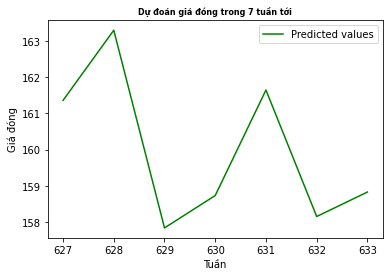

In [ ]:
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

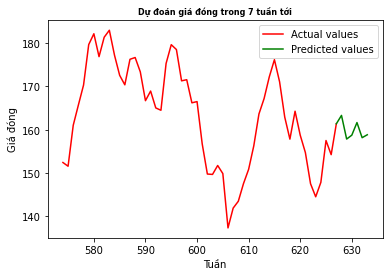

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_apple_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

#### 3.3 Mô hình Random Forest

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_apple,training_set_scaled,
                                                  time_step, split_percent)
# (2416, 60, 6), (2416, 1, 6), (65, 60, 6), (65, 1, 6)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2] 
X_train3 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train3 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor() # không parameter để test overfitting
start_time=timer(None)
regressor_rf.fit(X_train3, y_train3)
time_train_rf = timer(start_time)
print('Training time -', timer(start_time))

Training time - 0.0 giờ : 0.0 phút : 7.61 giây


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
X_test3 = X_test.reshape((X_test.shape[0], n_input))
y_test3 = y_test.reshape((y_test.shape[0], n_output))
#Test results
start_time=timer(None)
y_pred = regressor_rf.predict(X_test3)
time_test_rf = timer(start_time)
rf_mae = mean_absolute_error(y_test3, y_pred)
print('Testing time -', timer(start_time))
print('Mean Absolute Error:', rf_mae)
print('Mean Squared Error:', mean_squared_error(y_test3, y_pred))

Testing time - 0.0 giờ : 0.0 phút : 0.02 giây
Mean Absolute Error: 0.07410884107655186
Mean Squared Error: 0.009455242555824568


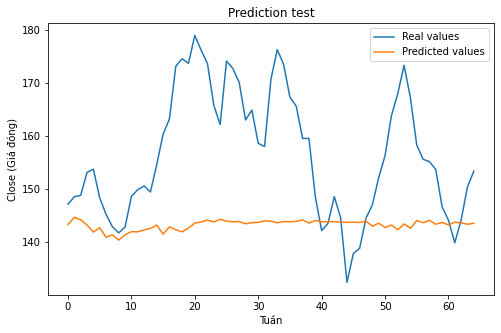

In [ ]:
#Reversing transform để có được giá trị dữ liệu thích hợp
y_test_rf = sc.inverse_transform(y_test3)
y_pred_rf = sc.inverse_transform(y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_test_rf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo bằng Random Forest và Vẽ đồ thị

In [ ]:
df_apple_real_pred = data_apple  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
df_apple_real_pred.shape

(627, 6)

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_apple_pred = df_apple_real_pred.iloc[-time_step:]
  X_input = df_apple_pred.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = X_input.reshape(1, n_input) # 1 phần tử chứa 540 # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array
  print(X_input.shape)
  rf_prediction = regressor_rf.predict(X_input)
  # y_pred = regressor_rf.predict(X_test3)
  rf_prediction = np.reshape(rf_prediction, (rf_prediction.shape[0], 6)) #reshaping for (1, 6)
   #inverse transform để có được giá trị dữ liệu phù hợp
  rf_prediction = sc.inverse_transform(rf_prediction)
  print("Random Forest, Giá đóng cửa cho tuần " + str(week) +":", rf_prediction[0,1])
  
  # Đưa dữ liệu vào bộ train
  df_apple_predicted = pd.DataFrame(rf_prediction, columns=df_apple.columns)
  data = [df_apple_real_pred, df_apple_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_apple_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_apple_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_apple_real_pred,training_set_scaled,
                                                  time_step, split_percent)

  # flatten input
  n_input = X_train.shape[1] * X_train.shape[2]
  X_train3 = X_train.reshape((X_train.shape[0], n_input))
  n_output = y_train.shape[2]
  y_train3 = y_train.reshape((y_train.shape[0], n_output))

  # huấn luyện lại mô hình
  regressor_rf.fit(X_train3, y_train3)


(1, 360)
Random Forest, Giá đóng cửa cho tuần 1: 165.993943224569
(1, 360)
Random Forest, Giá đóng cửa cho tuần 2: 167.69652094517184
(1, 360)
Random Forest, Giá đóng cửa cho tuần 3: 167.47324325649905
(1, 360)
Random Forest, Giá đóng cửa cho tuần 4: 167.10984131923206
(1, 360)
Random Forest, Giá đóng cửa cho tuần 5: 166.90688260244502
(1, 360)
Random Forest, Giá đóng cửa cho tuần 6: 168.07450339948866
(1, 360)
Random Forest, Giá đóng cửa cho tuần 7: 169.06386961421106


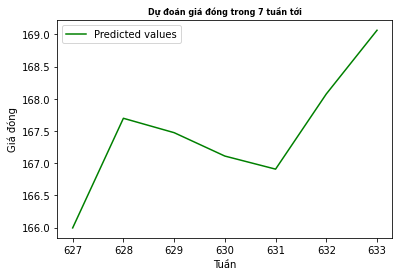

In [ ]:
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

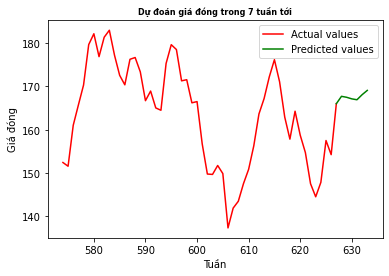

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_apple_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

#### 3.4 Đánh giá độ đo MAE và so sánh

In [ ]:
compare = pd.DataFrame({'Model': ['RNN', 'MLP', 'Random Forest'], 
                        'Mean Absolute Error': [rnn_mae, mlp_mae,  rf_mae]})
compare.sort_values(by='Mean Absolute Error', ascending=True)

,Model,Mean Absolute Error
1,MLP,0.030930
0,RNN,0.049900
2,Random Forest,0.074109


#### 3.5 Thời gian Training và Testing

In [ ]:
compare = pd.DataFrame({'Model': ['RNN', 'MLP', 'Random Forest'], 
                        'Training time': [time_train_rnn, time_train_mlp,  time_train_rf]})
compare.sort_values(by='Training time', ascending=True)

,Model,Training time
1,MLP,0.0 giờ : 0.0 phút : 1.09 giây
0,RNN,0.0 giờ : 0.0 phút : 3.23 giây
2,Random Forest,0.0 giờ : 0.0 phút : 7.61 giây


In [ ]:
compare = pd.DataFrame({'Model': ['RNN', 'MLP', 'Random Forest'], 
                        'Testing time': [time_test_rnn, time_test_mlp,  time_test_rf]})
compare.sort_values(by='Testing time', ascending=True)

,Model,Testing time
2,Random Forest,0.0 giờ : 0.0 phút : 0.02 giây
1,MLP,0.0 giờ : 0.0 phút : 0.11 giây
0,RNN,0.0 giờ : 0.0 phút : 0.31 giây


###(4) XỬ LÝ OVERFITTING VÀ SO SÁNH

In [ ]:
early_stopping = EarlyStopping(patience=2, min_delta=0.0001, monitor="val_loss", verbose=1)

#### 4.1 Mô hình RNN

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_apple,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
regressor_rnn = Sequential()
regressor_rnn.add(SimpleRNN(units=100, activation='relu',
                        input_shape = (X_train.shape[1], X_train.shape[2])))
regressor_rnn.add(Dropout(0.2))
regressor_rnn.add(RepeatVector(6))
regressor_rnn.add(SimpleRNN(units=100, activation='relu', return_sequences = True))
regressor_rnn.add(Dropout(0.2))
regressor_rnn.add(TimeDistributed(Dense(1))) # `TimeDistributed` Layer phải được chuyển qua `input_shape ` với ít nhât 3 dimen

# Bien dich RNN
regressor_rnn.compile(optimizer='adam', loss = 'mse', metrics=['mae'])#mean_squared_error
regressor_rnn.summary()

# huấn luyện mô hình RNN đã dropout với early stopping
regressor_rnn.fit(X_train, y_train, epochs = 5, batch_size = 32, validation_split=0.2, callbacks=[early_stopping],verbose=1)
# callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)]) validation_split=0.2 verbose=1

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 100)               10700     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 repeat_vector_9 (RepeatVect  (None, 6, 100)           0         
 or)                                                             
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 6, 100)            20100     
                                                                 
 dropout_13 (Dropout)        (None, 6, 100)            0         
                                                                 
 time_distributed_9 (TimeDis  (None, 6, 1)             101       
 tributed)                                           

3/3 [==============================] - 0s 7ms/step
(65, 6, 1)


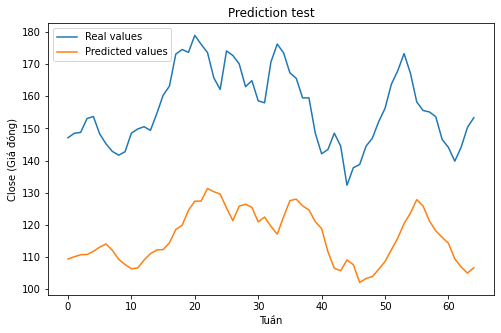

In [ ]:
#Test results
y_pred = regressor_rnn.predict(X_test)#verbose=1
print(y_pred.shape) #cần reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_rnn_ovf = sc.inverse_transform(y_test_inv)
y_pred_rnn_ovf = sc.inverse_transform(y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_test_rnn_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

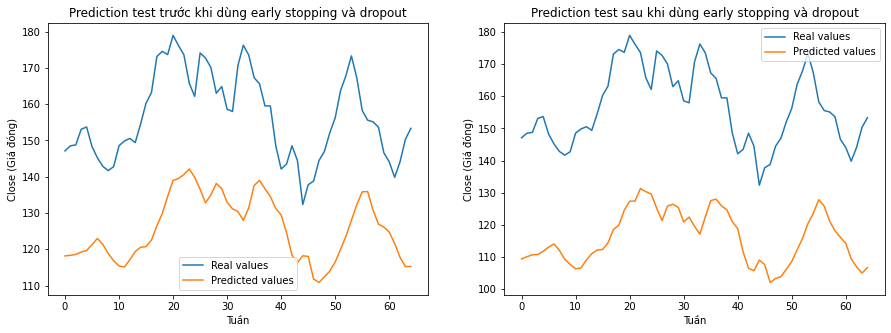

In [ ]:
# so sánh trước và sau khi xử lý overfiting
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(y_test_rnn[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test trước khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(y_test_rnn_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rnn_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test sau khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

#### 4.2 Mô hình MLP

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_apple,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train2 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train2 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
regressor_mlp = Sequential()
regressor_mlp.add(Dense(units=100, activation = "relu", input_dim=n_input))
regressor_mlp.add(Dropout(0.2))
regressor_mlp.add(Dense(units=100, activation = "relu"))
regressor_mlp.add(Dropout(0.2))
regressor_mlp.add(Dense(n_output))
# Bien dich MLP
regressor_mlp.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
regressor_mlp.summary()
# huấn luyện mô hình
regressor_mlp.fit(X_train2, y_train2, epochs = 5, batch_size = 32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 100)               36100     
                                                                 
 dropout_14 (Dropout)        (None, 100)               0         
                                                                 
 dense_26 (Dense)            (None, 100)               10100     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_27 (Dense)            (None, 6)                 606       
                                                                 
Total params: 46,806
Trainable params: 46,806
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
13/13 [==============================] 

3/3 [==============================] - 0s 3ms/step
(65, 6)


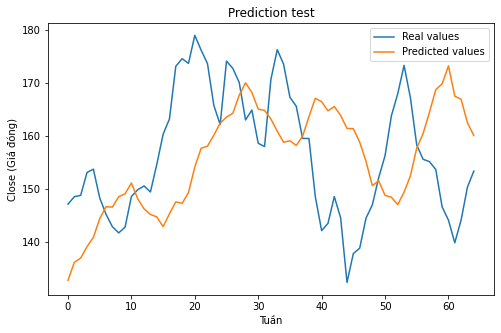

In [ ]:
# regressor.fit(X_train2, y_train, epochs = 5, batch_size = 32)
X_test2 = X_test.reshape((X_test.shape[0], n_input))

#Test results
y_pred = regressor_mlp.predict(X_test2)
print(y_pred.shape) #(65, 6)

#Reshape dữ liệu cho inverse transforming
y_test2 = y_test.reshape((y_test.shape[0], n_output)) #reshape (65, 6)
# y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_mlp_ovf = sc.inverse_transform(y_test2)
y_pred_mlp_ovf = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_mlp_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

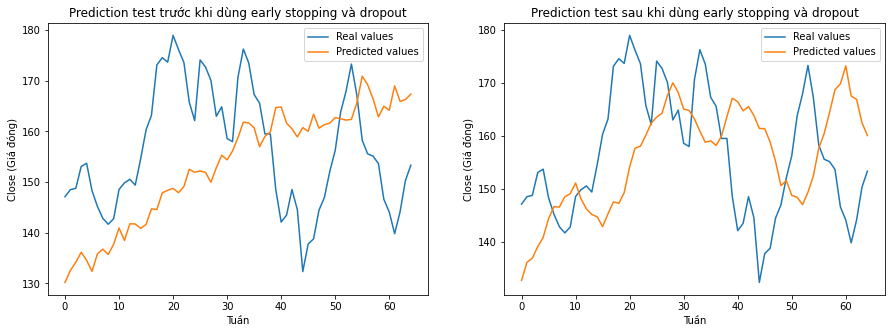

In [ ]:
# so sánh trước và sau khi xử lý overfiting
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(y_test_mlp[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test trước khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(y_test_mlp_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_mlp_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test sau khi dùng early stopping và dropout')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

#### 4.3 Mô hình Random forest

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_apple,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# flatten input
n_input = X_train.shape[1] * X_train.shape[2]
X_train3 = X_train.reshape((X_train.shape[0], n_input))
n_output = y_train.shape[2]
y_train3 = y_train.reshape((y_train.shape[0], n_output))

In [ ]:
# Tìm tham số tốt nhất để xử lý overfitting
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 5 , stop = 15, num = 10)] # returns 10 numbers 

max_features = ['auto', 'log2']

max_depth = [int(x) for x in np.linspace(5, 10, num = 2)] 

max_depth.append(None)

bootstrap = [True, False]

r_grid = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'bootstrap': bootstrap}
          
rfr = RandomForestRegressor(random_state = 1)

rfr_random = RandomizedSearchCV(estimator=rfr, param_distributions=r_grid, n_iter = 20, 
                                scoring='neg_mean_absolute_error', cv = 3, verbose=2, 
                                random_state=42, n_jobs=-1, return_train_score=True)

rfr_random.fit(X_train3, y_train3)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=1),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, None],
                                        'max_features': ['auto', 'log2'],
                                        'n_estimators': [5, 6, 7, 8, 9, 10, 11,
                                                         12, 13, 15]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=2)

In [ ]:
print(rfr_random.best_params_)

{'n_estimators': 6, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# có thể sử dụng nhiều tham số để loại bỏ phần thừa một cách dễ dàng
regressor_rf = RandomForestRegressor(n_estimators= 6, max_features= 'log2', 
                                     max_depth= 10, bootstrap= False) 
regressor_rf.fit(X_train3, y_train3)

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      n_estimators=6)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
X_test3 = X_test.reshape((X_test.shape[0], n_input))
y_test3 = y_test.reshape((y_test.shape[0], n_output)) # (65, 1, 6) -> (65, 6)
#Test results
y_pred = regressor_rf.predict(X_test3)
print('Mean Absolute Error:', mean_absolute_error(y_test3, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test3, y_pred))

Mean Absolute Error: 0.06989535731515449
Mean Squared Error: 0.008425108076547562


In [ ]:
y_test.shape

(65, 1, 6)

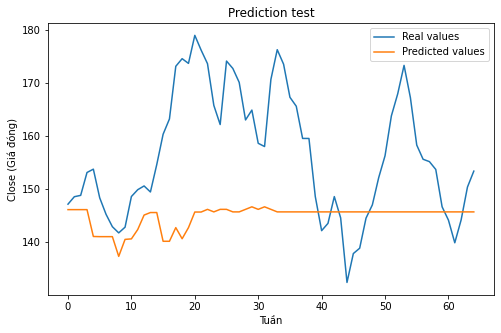

In [ ]:
#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_rf_ovf = sc.inverse_transform(y_test3)
y_pred_rf_ovf = sc.inverse_transform(y_pred)

plt.figure(figsize=(8,5))
plt.plot(y_test_rf_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

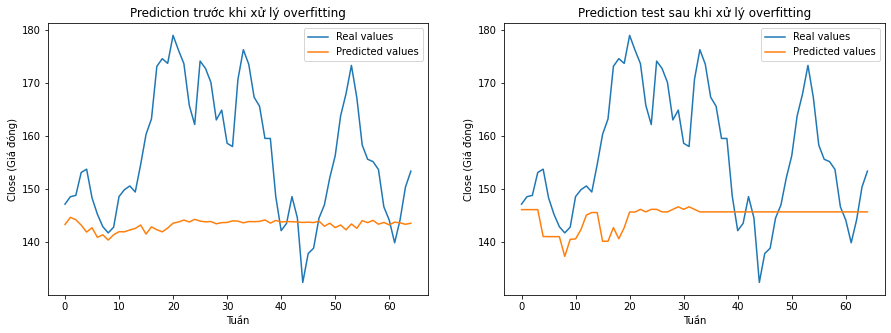

In [ ]:
# so sánh trước và sau khi xử lý overfiting
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1)
plt.plot(y_test_rf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction trước khi xử lý overfitting')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

plt.subplot(1, 2, 2) 
plt.plot(y_test_rf_ovf[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_rf_ovf[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test sau khi xử lý overfitting')
plt.xlabel('Tuần')
plt.ylabel('Close (Giá đóng)')
#plt.ylim([15, 28])
plt.legend()

###(5) TÌM ĐẶC TRƯNG QUAN TRỌNG NHẤT

In [ ]:
# Feature selection bằng ExtraTreesRegressor(dựa trên mô hình)
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc

In [ ]:
df_apple = df_apple
X = df_apple.drop(['Close'], axis=1)
y = df_apple['Close']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

In [ ]:
reg= ExtraTreesRegressor()
reg.fit(X_train,y_train)

ExtraTreesRegressor()

In [ ]:
reg.feature_importances_

array([0.30753629, 0.23227687, 0.18249687, 0.27539303, 0.00229695])

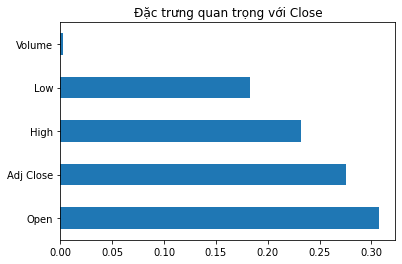

In [ ]:
feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(8).plot(kind='barh', title='Đặc trưng quan trọng với Close')
plt.show()

In [ ]:
feat_importances

Open         0.307536
High         0.232277
Low          0.182497
Adj Close    0.275393
Volume       0.002297
dtype: float64

In [ ]:
feat_importances[feat_importances == max(feat_importances)].index

Index(['Open'], dtype='object')

### (6) MÔ HÌNH DEEP LEARNING

#### 6.1 Mô hình LSTM

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_apple,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
# LSTM
def lstm():
  regressor_lstm = Sequential()
  regressor_lstm.add(LSTM(units=100,input_shape = (X_train.shape[1], X_train.shape[2])))
  regressor_lstm.add(Dropout(0.2))
  regressor_lstm.add(RepeatVector(6))
  regressor_lstm.add(LSTM(units=100, return_sequences = True))
  regressor_lstm.add(Dropout(0.2))
  regressor_lstm.add(TimeDistributed(Dense(1))) # `TimeDistributed` Layer phải được chuyển qua `input_shape ` với ít nhât 3 dimen

  # Bien dich LSTM
  regressor_lstm.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
  regressor_lstm.summary()
  return regressor_lstm

In [ ]:
# huấn luyện mô hình
regressor_lstm = lstm()
regressor_lstm.fit(X_train, y_train, epochs = 5, batch_size = 32,  shuffle = False)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 100)               42800     
                                                                 
 dropout_16 (Dropout)        (None, 100)               0         
                                                                 
 repeat_vector_10 (RepeatVec  (None, 6, 100)           0         
 tor)                                                            
                                                                 
 lstm_9 (LSTM)               (None, 6, 100)            80400     
                                                                 
 dropout_17 (Dropout)        (None, 6, 100)            0         
                                                                 
 time_distributed_10 (TimeDi  (None, 6, 1)             101       
 stributed)                                          

3/3 [==============================] - 1s 14ms/step
(65, 6, 1)


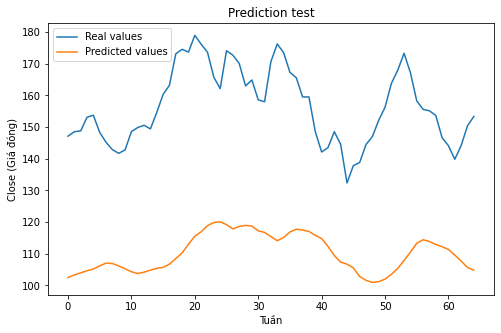

In [ ]:
#Test results
y_pred = regressor_lstm.predict(X_test)
print(y_pred.shape) #(65, 6, 1)  reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_inv = sc.inverse_transform(y_test_inv)
y_pred_lstm = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_inv[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_lstm[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán "
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo và Vẽ đồ thị

In [ ]:
df_apple_real_pred = data_apple  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_apple = df_apple_real_pred.iloc[-time_step:]
  X_input = df_apple.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1])) # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array

  LSTM_prediction = regressor_lstm.predict(X_input) # dự đoán cho tuần thứ 61
  LSTM_prediction.shape
  LSTM_prediction = np.reshape(LSTM_prediction, (LSTM_prediction.shape[0], 6)) #reshaping for (1, 1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  LSTM_prediction = sc.inverse_transform(LSTM_prediction)
  print("LSTM, Giá đóng cửa cho tuần " + str(week) +":", LSTM_prediction[0,1])

  # Đưa dữ liệu vào bộ train
  df_apple_predicted = pd.DataFrame(LSTM_prediction, columns=df_apple.columns)
  data = [df_apple_real_pred, df_apple_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_apple_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_apple_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_apple_real_pred,training_set_scaled,
                                                  time_step, split_percent)
  # huấn luyện lại mô hình
  regressor_lstm.fit(X_train, y_train, epochs = 5, batch_size = 32)


1/1 [==============================] - 0s 24ms/step
LSTM, Giá đóng cửa cho tuần 1: 150.58586
Epoch 1/5
16/16 [==============================] - 1s 46ms/step - loss: 0.0186 - mae: 0.0881
Epoch 2/5
16/16 [==============================] - 1s 47ms/step - loss: 0.0157 - mae: 0.0732
Epoch 3/5
16/16 [==============================] - 1s 45ms/step - loss: 0.0146 - mae: 0.0705
Epoch 4/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0143 - mae: 0.0680
Epoch 5/5
1/1 [==============================] - 0s 22ms/step
LSTM, Giá đóng cửa cho tuần 2: 151.7766
Epoch 1/5
16/16 [==============================] - 1s 45ms/step - loss: 0.0140 - mae: 0.0676
Epoch 2/5
16/16 [==============================] - 1s 45ms/step - loss: 0.0140 - mae: 0.0670
Epoch 3/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0139 - mae: 0.0673
Epoch 4/5
16/16 [==============================] - 1s 44ms/step - loss: 0.0140 - mae: 0.0669
Epoch 5/5
1/1 [==============================] - 0s 24ms/step

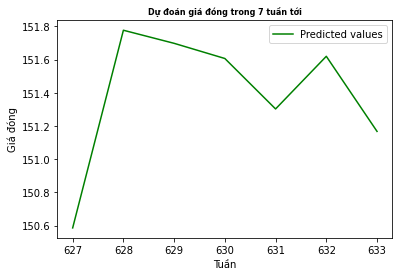

In [ ]:
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1 là giá đóng
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

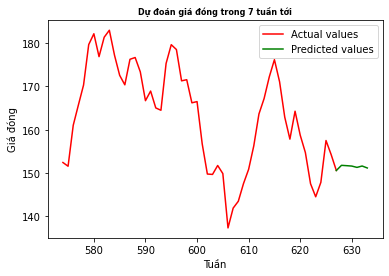

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_apple_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1 là giá đóng
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

#### 6.2 Mô hình BiLSTM 

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_apple,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional
def bilstm():
    regressor_bilstm = Sequential()
    # Input layer
    regressor_bilstm.add(Bidirectional(
              LSTM(units = 100), input_shape=(X_train.shape[1], X_train.shape[2])))
    regressor_bilstm.add(RepeatVector(6))
    # Hidden layer
    regressor_bilstm.add(Bidirectional(LSTM(units = 100, return_sequences = True)))
    regressor_bilstm.add(TimeDistributed(Dense(1)))
    #Compile model
    regressor_bilstm.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
    regressor_bilstm.summary()

    return regressor_bilstm

In [ ]:
regressor_bilstm = bilstm()
start_time=timer(None)
regressor_bilstm.fit( X_train, y_train, epochs = 5, batch_size = 32)
timer(start_time)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 200)              85600     
 nal)                                                            
                                                                 
 repeat_vector_11 (RepeatVec  (None, 6, 200)           0         
 tor)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 6, 200)           240800    
 nal)                                                            
                                                                 
 time_distributed_11 (TimeDi  (None, 6, 1)             201       
 stributed)                                                      
                                                                 
Total params: 326,601
Trainable params: 326,601
Non-t

'0.0 giờ : 0.0 phút : 14.94 giây'

3/3 [==============================] - 2s 17ms/step
(65, 6, 1)


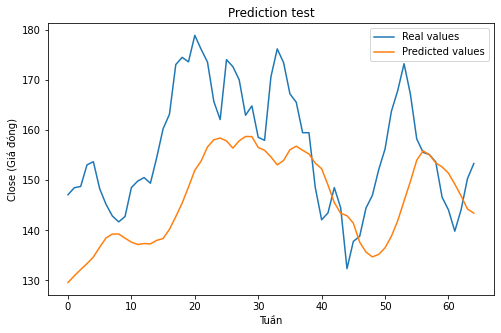

In [ ]:
#Test results
y_pred = regressor_bilstm.predict(X_test)
print(y_pred.shape) #(65, 6, 1) - reshaped thành (65, 1, 6)

#Reshape dữ liệu cho inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshape (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshape (65, 1, 6)

#Inverse transform để có được giá trị dữ liệu phù hợp
y_test_inv = sc.inverse_transform(y_test_inv)
y_pred_bilstm = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_inv[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.plot(y_pred_bilstm[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3 là giá đóng
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán
plt.legend()
plt.show()

##### Dự đoán 7 tuần tiếp theo và Vẽ đồ thị

In [ ]:
df_apple_real_pred = data_apple  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_apple = df_apple_real_pred.iloc[-time_step:]
  X_input = df_apple.values # lấy 60 hàng cuối cùng và chuyển thành array
  X_input = sc.fit_transform(X_input) # convert thành 2D array và scale
  X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1])) # chỉ 1 phần tử chứa 60 phần tử con có 6 cột, reshape convert thành 3D array

  biLSTM_prediction = regressor_bilstm.predict(X_input)
  biLSTM_prediction.shape
  biLSTM_prediction = np.reshape(biLSTM_prediction, (biLSTM_prediction.shape[0], 6)) #reshape (1, 1, 6)
  #inverse transform để có được giá trị dữ liệu phù hợp
  biLSTM_prediction = sc.inverse_transform(biLSTM_prediction)
  print("BiLSTM, Giá đóng cửa cho tuần " + str(week) +":", biLSTM_prediction[0,1])

  # Đưa dữ liệu vào bộ train
  df_apple_predicted = pd.DataFrame(biLSTM_prediction, columns=df_apple.columns)
  data = [df_apple_real_pred, df_apple_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_apple_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_apple_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_apple_real_pred,training_set_scaled,
                                                  time_step, split_percent)
  # huấn luyện lại mô hình
  regressor_bilstm.fit(X_train, y_train, epochs = 5, batch_size = 32)


1/1 [==============================] - 0s 24ms/step
BiLSTM, Giá đóng cửa cho tuần 1: 153.84113
Epoch 1/5
16/16 [==============================] - 1s 82ms/step - loss: 0.0138 - mae: 0.0667
Epoch 2/5
16/16 [==============================] - 1s 83ms/step - loss: 0.0136 - mae: 0.0665
Epoch 3/5
16/16 [==============================] - 1s 81ms/step - loss: 0.0135 - mae: 0.0646
Epoch 4/5
16/16 [==============================] - 1s 79ms/step - loss: 0.0135 - mae: 0.0653
Epoch 5/5
1/1 [==============================] - 0s 29ms/step
BiLSTM, Giá đóng cửa cho tuần 2: 154.15848
Epoch 1/5
16/16 [==============================] - 1s 82ms/step - loss: 0.0135 - mae: 0.0653
Epoch 2/5
16/16 [==============================] - 1s 82ms/step - loss: 0.0134 - mae: 0.0641
Epoch 3/5
16/16 [==============================] - 1s 80ms/step - loss: 0.0134 - mae: 0.0657
Epoch 4/5
16/16 [==============================] - 1s 82ms/step - loss: 0.0134 - mae: 0.0650
Epoch 5/5
1/1 [==============================] - 0s 28ms

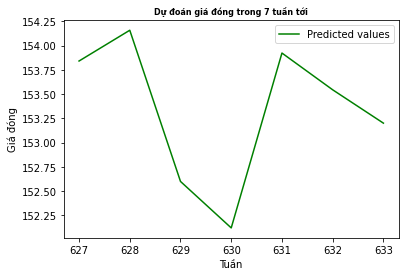

In [ ]:
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

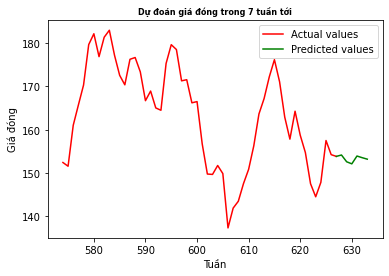

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_apple_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

In [ ]:
X_train, y_train, X_test, y_test = split_sequences(data_apple,training_set_scaled,
                                                  time_step, split_percent)

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
def cnn():
    regressor_cnn = Sequential()
    # Input layer
    regressor_cnn.add(Conv1D(100, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]) ))
    regressor_cnn.add(MaxPooling1D())
    regressor_cnn.add(Conv1D(100, kernel_size=3, activation='relu'))
    regressor_cnn.add(MaxPooling1D())
    regressor_cnn.add(Flatten())
    regressor_cnn.add(RepeatVector(6))
    # Hidden layer
    regressor_cnn.add(TimeDistributed(Dense(1)))
    #Compile model
    regressor_cnn.compile(optimizer='adam', loss = 'mse', metrics=['mae'])
    regressor_cnn.summary()

    return regressor_cnn

In [ ]:
regressor_cnn = cnn()
start_time=timer(None)
regressor_cnn.fit( X_train, y_train, epochs = 5, batch_size = 32)
timer(start_time)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 58, 100)           1900      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 100)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 100)           30100     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 13, 100)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1300)              0         
                                                                 
 repeat_vector_12 (RepeatVec  (None, 6, 1300)        

'0.0 giờ : 0.0 phút : 1.79 giây'

3/3 [==============================] - 0s 6ms/step
(65, 6, 1)


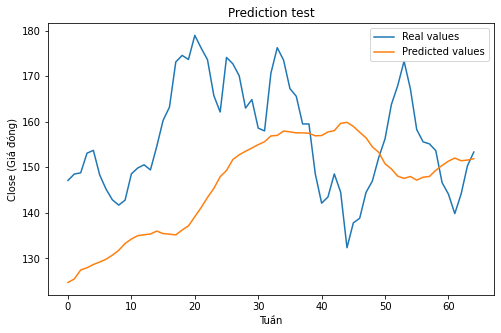

In [ ]:
#Test results
y_pred = regressor_cnn.predict(X_test)
print(y_pred.shape) #(65, 6, 1) - need to be reshaped for (65, 1, 6)

#Reshaping data for inverse transforming
y_test_inv = np.reshape(y_test, (y_test.shape[0], 6)) #reshaping for (65, 1, 6)
y_pred = np.reshape(y_pred, (y_pred.shape[0], 6)) #reshaping for (65, 1, 6)

#Reversing transform to get proper data values
y_test_inv = sc.inverse_transform(y_test_inv)
y_pred_lstm = sc.inverse_transform(y_pred)

# Plot
plt.figure(figsize=(8,5))
plt.plot(y_test_inv[:, 3], label = 'Real values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3
plt.plot(y_pred_lstm[:, 3], label = 'Predicted values') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 3
plt.title('Prediction test')
plt.xlabel('Tuần')
#plt.ylim([15, 28])
plt.ylabel('Close (Giá đóng)') #Hiển thị giá trị của cột 3 cho dự đoán "
plt.legend()
plt.show()

In [ ]:
df_apple_real_pred = data_apple  # tạo 1 bộ bao gồm cả dữ liệu thật và cho việc chứa kq dự đoán

In [ ]:
week = 0
for i in range(future_prediction):
  week += 1
  df_apple = df_apple_real_pred.iloc[-time_step:]
  X_input = df_apple.values # getting last 60 rows and converting to array
  X_input = sc.fit_transform(X_input) # converting to 2D array and scaling
  X_input = np.reshape(X_input, (1,X_input.shape[0],X_input.shape[1])) # chỉ 1 phần tử chứa 60 phần tử con có 6 cột                    # reshaping : converting to 3D array

  biLSTM_prediction = regressor_cnn.predict(X_input)
  biLSTM_prediction.shape
  biLSTM_prediction = np.reshape(biLSTM_prediction, (biLSTM_prediction.shape[0], 6)) #reshaping for (1, 1, 6)
  #Reversing transform to get proper data values
  biLSTM_prediction = sc.inverse_transform(biLSTM_prediction)
  print("BiLSTM, Giá đóng cửa cho tuần " + str(week) +":", biLSTM_prediction[0,1])

  # Đưa dữ liệu vào bộ train
  df_apple_predicted = pd.DataFrame(biLSTM_prediction, columns=df_apple.columns)
  data = [df_apple_real_pred, df_apple_predicted] # gộp 2 bộ dữ liệu lại thành 1
  df_apple_real_pred = pd.concat(data).reset_index(drop = True)

  # Làm lại các bước giống trên
  training_set_repeat = df_apple_real_pred.values
  training_set_scaled_repeat = sc.fit_transform(training_set_repeat)

  # chia bộ dữ liệu
  X_train, y_train, X_test, y_test = split_sequences(df_apple_real_pred,training_set_scaled,
                                                  time_step, split_percent)
  # huấn luyện lại mô hình
  regressor_cnn.fit(X_train, y_train, epochs = 5, batch_size = 32)


1/1 [==============================] - 0s 20ms/step
BiLSTM, Giá đóng cửa cho tuần 1: 161.72311
Epoch 1/5
16/16 [==============================] - 0s 13ms/step - loss: 0.0139 - mae: 0.0688
Epoch 2/5
16/16 [==============================] - 0s 12ms/step - loss: 0.0139 - mae: 0.0675
Epoch 3/5
16/16 [==============================] - 0s 13ms/step - loss: 0.0140 - mae: 0.0689
Epoch 4/5
16/16 [==============================] - 0s 13ms/step - loss: 0.0140 - mae: 0.0687
Epoch 5/5
1/1 [==============================] - 0s 20ms/step
BiLSTM, Giá đóng cửa cho tuần 2: 158.18073
Epoch 1/5
16/16 [==============================] - 0s 13ms/step - loss: 0.0138 - mae: 0.0669
Epoch 2/5
16/16 [==============================] - 0s 13ms/step - loss: 0.0136 - mae: 0.0678
Epoch 3/5
16/16 [==============================] - 0s 12ms/step - loss: 0.0137 - mae: 0.0683
Epoch 4/5
16/16 [==============================] - 0s 13ms/step - loss: 0.0137 - mae: 0.0674
Epoch 5/5
1/1 [==============================] - 0s 17ms

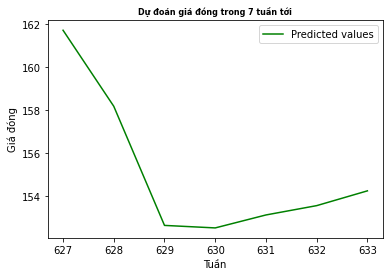

In [ ]:
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()

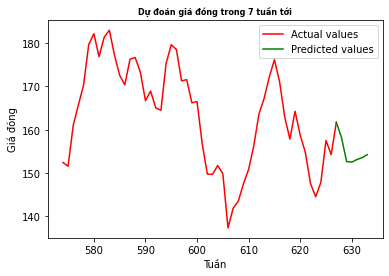

In [ ]:
# Vẽ đồ thị từ bộ dữ liệu chứa cả phần dữ liệu thật + predict cho tương lai
plt.plot(df_apple_real_pred.iloc[-time_step:628,1], label = 'Actual values', color='r')
plt.plot(df_apple_real_pred.iloc[-future_prediction:,1], label = 'Predicted values', color='g') #Chọn 1 cột để hiển thị - ở đây nhóm chọn cột 1
plt.title("Dự đoán giá đóng trong 7 tuần tới", fontsize=8, fontweight='bold')
plt.xlabel("Tuần")
plt.ylabel("Giá đóng")
plt.legend()